## Lab 6: Variable Selection and Regularization

### Dataset: Baseball Players

In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

**Format**: A data frame with 322 observations of major league players on the following 20 variables.

`AtBat` Number of times at bat in 1986

`Hits` Number of hits in 1986

`HmRun` Number of home runs in 1986

`Runs` Number of runs in 1986

`RBI` Number of runs batted in in 1986

`Walks` Number of walks in 1986

`Years` Number of years in the major leagues

`CAtBat` Number of times at bat during his career

`CHits` Number of hits during his career

`CHmRun` Number of home runs during his career

`CRuns` Number of runs during his career

`CRBI` Number of runs batted in during his career

`CWalks` Number of walks during his career

`League` A factor with levels A and N indicating player’s league at the end of 1986

`Division` A factor with levels E and W indicating player’s division at the end of 1986

`PutOuts` Number of put outs in 1986

`Assists` Number of assists in 1986

`Errors` Number of errors in 1986

`Salary` 1987 annual salary on opening day in thousands of dollars

`NewLeague` A factor with levels A and N indicating player’s league at the beginning of 1987

A couple notes about this lab:

Although it isn’t listed as a specific question, don’t forget to clean your

1.   Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?
2.   There are a **lot** of variables in the dataset! You may want to use the `remainder = "passthrough"` trick in your column transformers, rather than typing out a ton of gene names.
3.   Don’t forget that in penalized regression, we **must** standardize our numeric variables.
4.   There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.

## Prep: Import Data and Data Cleaning

In [ ]:

from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['Hitters.csv']))

Saving Hitters.csv to Hitters.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from plotnine import *

In [ ]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
df.dtypes

,0
AtBat,int64
Hits,int64
HmRun,int64
Runs,int64
RBI,int64
Walks,int64
Years,int64
CAtBat,int64
CHits,int64
CHmRun,int64


* **Numeric:**  Variables like `AtBat`, `Hits`, `HmRun`, `Runs`, `RBI`, `Walks`, `Years`, `CAtBat`, `CHits`, `CHmRun`, `CRuns`, `CRBI`, `CWalks`, `PutOuts`, `Assists`, `Errors`, and `Salary` are represented as integers or floating-point numbers.
* **Categorical:** Variables like `League`, `Division`, and `NewLeague` are represented as objects..

In [ ]:
df = df.dropna()
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [ ]:
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


## Part 1: Different Model Specs

### A. Regression without regularization



1.   Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary linear regression
2.   Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.
3.   Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.






In [ ]:
X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

In [ ]:
Column_Transformer = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown = "ignore"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

linear_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("linear_regression", LinearRegression())]
)

linear_regression.fit(X, y)

lin_coefs = linear_regression.named_steps['linear_regression'].coef_

lin_cols = (linear_regression.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())



coefs_with_names = list(zip(lin_cols, lin_coefs))

lin_sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

print("Significant Coefficients:")
for feature, coef in lin_sorted_coefs[:10]:
    print(f"{feature}: {coef}")

Significant Coefficients:
CRuns: 480.74713477079285
CAtBat: -391.0386546635357
Hits: 337.8304794814839
AtBat: -291.0945556971506
CRBI: 260.68988580523137
CWalks: -213.89225864291296
Walks: 135.07389695131226
CHits: 86.68761663771805
PutOuts: 78.76129639492679
Runs: -60.57247860551047


In [ ]:
lin_coefs = linear_regression.named_steps['linear_regression'].coef_
lin_coefs

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [ ]:
def get_coefficients_df(pipeline):
    """
    Extracts feature names and coefficients from a linear regression pipeline and
    returns them as a sorted DataFrame.

    Parameters:
    pipeline (Pipeline): A fitted pipeline with preprocessing and a linear regression model.

    Returns:
    pd.DataFrame: DataFrame with feature names and coefficients, sorted by coefficient value.
    """
    # Extract feature names from the preprocessing step
    feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

    # Extract coefficients from the linear regression step
    coefficient_list = pipeline.named_steps['linear_regression'].coef_

    # Create a DataFrame with variable names and coefficients
    coeff_var_df = pd.DataFrame({
        "variable_name": feature_names,
        "coefficients": coefficient_list
    })

    # Sort the DataFrame by coefficient values in descending order
    coeff_var_df = coeff_var_df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return coeff_var_df

model = linear_regression
coefficients_df_linear = get_coefficients_df(model)
coefficients_df_linear

,variable_name,coefficients
0,standardize__CRuns,480.747135
1,standardize__Hits,337.830479
2,standardize__CRBI,260.689886
3,standardize__Walks,135.073897
4,standardize__CHits,86.687617
5,standardize__PutOuts,78.761296
6,dummify__Division_E,58.424623
7,standardize__Assists,53.732490
8,standardize__HmRun,37.853837
9,dummify__League_N,31.299712


Given the data, while keeping other factors constant, each additional Career Run (CRuns) is estimated to boost a player’s salary by around $480.75, underscoring the value placed on players who actively contribute to team scoring. Similarly, each extra Hit is associated with an increase of approximately $337.8 in salary, reflecting the importance of successful offensive actions. On the other hand, every additional Career At Bat (CATBat) tends to reduce salary by about $391.04, suggesting that simply accumulating at-bats without substantial results may not favorably impact a player’s earning potential.

Additionally, a high coefficient for Career RBIs (CRBI) indicates that players who drive in runs receive higher compensation, with each additional RBI aligning with a positive salary adjustment of approximately $260.69. However, Career Walks (CWalks) show a negative association with salary, where each additional walk correlates with a reduction of around $213.98, perhaps signaling that a more passive offensive approach is less valued in terms of salary. Lastly, variables like Division (dummy variable for `Division_E`) and League (dummy variable for `League_N` or `League_A`) also influence salary, with slight positive or negative impacts, indicating that structural factors such as division or league affiliation can subtly affect player earnings, though less significantly than key performance metrics like Runs and Hits.

In [ ]:
# Calculate cross-validated MSE
mse_scores = -cross_val_score(linear_regression, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = np.mean(mse_scores)

print(f"Cross-validated MSE: {mean_mse}")

Cross-validated MSE: 121136.31031816891


The cross-validated mean squared error (MSE) of approximately 121,136 provides an estimate of the average squared prediction error for 1989 salaries using this model. This value suggests the typical deviation between actual and predicted salaries. By using cross-validation, we obtain a more robust error estimate, indicating how well the model might generalize to new data.

### B. Ridge regression



1.   Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression
2.   Use cross-validation to **tune** the λ hyperparameter.
3.   Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.
4.   Report the MSE you would expect if you used this pipeline to predict 1989 salaries.




In [ ]:
def ridge_regression_pipeline(X, y, alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, scoring="neg_mean_squared_error"):
    """
    Creates and fits a Ridge regression pipeline with cross-validation to determine
    the best alpha value.

    Parameters:
    X (pd.DataFrame): Predictor variables.
    y (pd.Series): Target variable.
    alphas (list): List of alpha values for Ridge regularization.
    cv (int): Number of cross-validation folds.
    scoring (str): Scoring metric for cross-validation.

    Returns:
    pd.DataFrame: DataFrame with alphas and corresponding cross-validated MSE scores.
    """
    # Define the preprocessing step
    column_transformer = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Define Ridge regression pipeline
    ridge_pipeline = Pipeline(
        [("preprocessing", column_transformer),
         ("ridge_regression", Ridge())]
    ).set_output(transform="pandas")

    # Define parameter grid for GridSearchCV
    param_grid = {"ridge_regression__alpha": alphas}

    # Perform cross-validation with GridSearchCV
    gscv = GridSearchCV(ridge_pipeline, param_grid, cv=cv, scoring=scoring)
    gscv_fitted = gscv.fit(X, y)

    # Extract and convert MSE scores to positive values
    positive_mse_scores = -gscv_fitted.cv_results_["mean_test_score"]

    # Create a DataFrame of alphas and scores
    results_df = pd.DataFrame({
        "alphas": alphas,
        "scores": positive_mse_scores
    })

    return results_df


results = ridge_regression_pipeline(X, y)
results

,alphas,scores
0,0.001,121124.458592
1,0.010,121022.903286
2,0.100,120343.621067
3,1.000,119144.432677
4,10.000,119348.984776


The best alpha is 1 since it has the lowest MSE value. The MSE of approximately 119144.432677 provides an estimate of the average squared prediction error for 1989 salaries using this model.

2.   Use cross-validation to tune the λ hyperparameter.

In [ ]:
def fit_ridge_regression_pipeline(X, y, alpha=1, top_n=5):
    """
    Fits a Ridge regression pipeline to the dataset with a specified alpha,
    and outputs the most significant coefficients.

    Parameters:
    X (pd.DataFrame): Predictor variables.
    y (pd.Series): Target variable.
    alpha (float): Regularization strength for Ridge regression.
    top_n (int): Number of top significant coefficients to display.

    Returns:
    pd.DataFrame: DataFrame with the most significant features and their coefficients.
    """
    # Define the preprocessing step
    column_transformer = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Define Ridge regression pipeline
    ridge_pipeline = Pipeline(
        [("preprocessing", column_transformer),
         ("ridge_regression", Ridge(alpha=1))] # name this step 'ridge_regression'
    ).set_output(transform="pandas")

    # Fit the pipeline to the data
    ridge_pipeline.fit(X, y)

    # Extract coefficients and feature names
    ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_ # Access coefficients using the correct step name
    ridge_cols = (ridge_pipeline.named_steps['preprocessing']
                      .transformers_[0][1]
                      .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                      .tolist() +
                  X.select_dtypes(include=[np.number]).columns.tolist())

    # Combine feature names with coefficients and sort by significance
    coefs_with_names = list(zip(ridge_cols, ridge_coefs))
    ridge_sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

    # Display the top N significant coefficients
    top_features_df = pd.DataFrame(ridge_sorted_coefs[:top_n], columns=["Feature", "Coefficient"])
    print("Most significant coefficients:")

    return top_features_df, ridge_pipeline # Return the pipeline

top_coefficients, ridge_pipeline = fit_ridge_regression_pipeline(X, y, alpha=1) # Store the pipeline
top_coefficients

Most significant coefficients:


,Feature,Coefficient
0,CRuns,320.412169
1,Hits,296.645050
2,AtBat,-270.686441
3,CAtBat,-225.406548
4,CWalks,-184.423611


In [ ]:
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_
ridge_coefs

array([ -30.43885531,   30.43885531,   60.01559493,  -60.01559493,
         13.11128155,  -13.11128155, -270.6864407 ,  296.64505003,
         18.10059158,  -29.33940613,   -9.11329453,  124.40717273,
        -38.66774782, -225.40654798,  126.65960655,   39.07092364,
        320.41216891,  160.38678418, -184.4236106 ,   78.62365619,
         47.46259711,  -23.72419031])

3.   Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients

In [ ]:

best_alpha = 1
column_transformer = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

ridge_pipeline_final = Pipeline(
    [("preprocessing", column_transformer),
     ("ridge_regression", Ridge(alpha=best_alpha))]
)

ridge_pipeline_final.fit(X, y)


def get_coefficients_df_ridge(pipeline):
    """
    Extracts feature names and coefficients from a Ridge regression pipeline and
    returns them as a sorted DataFrame.

    Parameters:
    pipeline (Pipeline): A fitted pipeline with preprocessing and a Ridge regression model.

    Returns:
    pd.DataFrame: DataFrame with feature names and coefficients, sorted by coefficient value.
    """
    feature_names = pipeline[:-1].get_feature_names_out()

    coefficient_list = pipeline.named_steps['ridge_regression'].coef_

    coeff_var_df = pd.DataFrame({
        "variable_name": feature_names,
        "coefficients": coefficient_list
    })

    # Sort the DataFrame by coefficient values in descending order
    coeff_var_df = coeff_var_df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return coeff_var_df

coefficients_df_ridge = get_coefficients_df_ridge(ridge_pipeline_final)
coefficients_df_ridge


,variable_name,coefficients
0,standardize__CRuns,320.412169
1,standardize__Hits,296.645050
2,standardize__CRBI,160.386784
3,standardize__CHits,126.659607
4,standardize__Walks,124.407173
5,standardize__PutOuts,78.623656
6,dummify__Division_E,60.015595
7,standardize__Assists,47.462597
8,standardize__CHmRun,39.070924
9,dummify__League_N,30.438855


In this Ridge regression model, the coefficients reflect the relationship between each predictor variable and the target variable, **Salary**. For instance, **CRuns** (Career Runs) has the highest positive coefficient (320.41), suggesting that players with higher career runs tend to have higher salaries, as scoring is likely valued in salary decisions. Similarly, **Hits** (296.65) and **CRBI** (Career Runs Batted In) (160.39) also have strong positive associations with salary, implying that consistent batting performance and run production are significant factors that increase a player’s earning potential. Conversely, **AtBat** has a substantial negative coefficient (-270.69), indicating that a higher number of at-bats could be associated with lower salaries, possibly due to diminishing returns on performance metrics or overexposure. These coefficients highlight that performance metrics directly related to scoring and productivity are highly valued in determining salary, whereas other metrics may not contribute positively to earnings.

4.   Report the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [ ]:
from sklearn.model_selection import cross_val_score

# Use ridge_pipeline_final instead of ridge_regression
ridge_scores = cross_val_score(ridge_pipeline_final, X, y, cv=5, scoring="neg_mean_squared_error")

ridge_mse = -ridge_scores.mean()

print("Cross-validated MSE:", ridge_mse)

Cross-validated MSE: 119144.43267691585


The best alpha is 1 since it has the lowest MSE value. The MSE of approximately 119144.432677 provides an estimate of the average squared prediction error for 1989 salaries using this model.

### C. Lasso regression



1.   Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary ridge regression
2.   Use cross-validation to **tune** the λ hyperparameter.
3.   Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.
4.   Report the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [ ]:
def lasso_regression_pipeline(X, y, alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, scoring="neg_mean_squared_error"):
    """
    Creates and fits a Lasso regression pipeline with cross-validation to determine
    the best alpha value.

    Parameters:
    X (pd.DataFrame): Predictor variables.
    y (pd.Series): Target variable.
    alphas (list): List of alpha values for Lasso regularization.
    cv (int): Number of cross-validation folds.
    scoring (str): Scoring metric for cross-validation.

    Returns:
    pd.DataFrame: DataFrame with alphas and corresponding cross-validated MSE scores.
    """
    # Define the preprocessing step
    column_transformer = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Define Lasso regression pipeline
    lasso_pipeline = Pipeline(
        [("preprocessing", column_transformer),
         ("lasso_regression", Lasso())]
    ).set_output(transform="pandas")

    # Define parameter grid for GridSearchCV
    param_grid = {"lasso_regression__alpha": alphas}

    # Perform cross-validation with GridSearchCV
    gscv = GridSearchCV(lasso_pipeline, param_grid, cv=cv, scoring=scoring)
    gscv_fitted = gscv.fit(X, y)

    # Extract and convert MSE scores to positive values
    positive_mse_scores = -gscv_fitted.cv_results_["mean_test_score"]

    # Create a DataFrame of alphas and scores
    results_df = pd.DataFrame({
        "alphas": alphas,
        "scores": positive_mse_scores
    })

    return results_df
results

,alphas,scores
0,0.001,121124.458592
1,0.010,121022.903286
2,0.100,120343.621067
3,1.000,119144.432677
4,10.000,119348.984776


The best alpha is 1 since it has the lowest MSE value. The MSE of approximately 119761.587407 provides an estimate of the average squared prediction error for 1989 salaries using this model.

2.   Use cross-validation to tune the λ hyperparameter.

In [ ]:
def fit_lasso_regression_pipeline(X, y, alpha=1, top_n=5):
    """
    Fits a Lasso regression pipeline to the dataset with a specified alpha,
    and outputs the most significant coefficients.

    Parameters:
    X (pd.DataFrame): Predictor variables.
    y (pd.Series): Target variable.
    alpha (float): Regularization strength for Lasso regression.
    top_n (int): Number of top significant coefficients to display.

    Returns:
    tuple: A tuple containing the fitted lasso pipeline and the DataFrame with the most significant features and their coefficients.
    """
    # Define the preprocessing step
    column_transformer = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Define Lasso regression pipeline
    lasso_pipeline = Pipeline(
        [("preprocessing", column_transformer),
         ("lasso_regression", Lasso(alpha=1))]
    ).set_output(transform="pandas")

    # Fit the pipeline to the data
    lasso_pipeline.fit(X, y)

    # Extract coefficients and feature names
    lasso_coefs = lasso_pipeline.named_steps["lasso_regression"].coef_
    lasso_cols = (lasso_pipeline.named_steps["preprocessing"]
                      .transformers_[0][1]
                      .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                      .tolist() +
                  X.select_dtypes(include=[np.number]).columns.tolist())

    # Combine feature names with coefficients and sort by significance
    coefs_with_names = list(zip(lasso_cols, lasso_coefs))
    lasso_sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

    # Display the top N significant coefficients
    top_features_df = pd.DataFrame(lasso_sorted_coefs[:top_n], columns=["Feature", "Coefficient"])
    print("Most significant coefficients:")

    return top_features_df

top_coefficients = fit_lasso_regression_pipeline(X, y, alpha=1)
top_coefficients


Most significant coefficients:


,Feature,Coefficient
0,CRuns,375.565519
1,Hits,304.359509
2,AtBat,-282.370957
3,CRBI,192.610892
4,CWalks,-189.644642


In [ ]:
lasso_pipeline = Pipeline(
    [("preprocessing", column_transformer),
     ("lasso_regression", Lasso(alpha=1))]
).set_output(transform="pandas")

lasso_pipeline.fit(X, y)

lasso_coefs = lasso_pipeline.named_steps["lasso_regression"].coef_
lasso_coefs

array([-3.58260721e+01,  9.97464147e-14,  1.14412951e+02, -2.07892950e-11,
        0.00000000e+00, -0.00000000e+00, -2.82370957e+02,  3.04359509e+02,
        1.11270220e+01, -2.49665071e+01, -0.00000000e+00,  1.20695275e+02,
       -3.49481481e+01, -1.62639794e+02,  0.00000000e+00,  1.42259932e+01,
        3.75565519e+02,  1.92610892e+02, -1.89644642e+02,  7.87603658e+01,
        4.19966795e+01, -1.84793784e+01])

3.   Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

In [ ]:
best_alpha = 1
column_transformer = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

lasso_pipeline_final = Pipeline(
    [("preprocessing", column_transformer),
     ("lasso_regression", Lasso(alpha=best_alpha))]
)

lasso_pipeline_final.fit(X, y)


def get_coefficients_df_lasso(pipeline):
    """
    Extracts feature names and coefficients from a Lasso regression pipeline and
    returns them as a sorted DataFrame.

    Parameters:
    pipeline (Pipeline): A fitted pipeline with preprocessing and a Lasso regression model.

    Returns:
    pd.DataFrame: DataFrame with feature names and coefficients, sorted by coefficient value.
    """
    feature_names = pipeline[:-1].get_feature_names_out()

    coefficient_list = pipeline.named_steps['lasso_regression'].coef_

    coeff_var_df = pd.DataFrame({
        "variable_name": feature_names,
        "coefficients": coefficient_list
    })

    # Sort the DataFrame by coefficient values in descending order
    coeff_var_df = coeff_var_df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return coeff_var_df

coefficients_df_lasso = get_coefficients_df_lasso(lasso_pipeline_final)
coefficients_df_lasso


,variable_name,coefficients
0,standardize__CRuns,3.755655e+02
1,standardize__Hits,3.043595e+02
2,standardize__CRBI,1.926109e+02
3,standardize__Walks,1.206953e+02
4,dummify__Division_E,1.144130e+02
5,standardize__PutOuts,7.876037e+01
6,standardize__Assists,4.199668e+01
7,standardize__CHmRun,1.422599e+01
8,standardize__HmRun,1.112702e+01
9,dummify__League_N,9.974641e-14


4.    Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [ ]:
lasso_scores = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error")

lasso_mse = -lasso_scores.mean()

print("Cross-validated MSE:", lasso_mse)

Cross-validated MSE: 119761.58740741308


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03


The best alpha is 1 since it has the lowest MSE value. The MSE of approximately 119761.58740741308 provides an estimate of the average squared prediction error for 1989 salaries using this model.

### D. Elastic Net

1.   Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression
2.   Use cross-validation to **tune** the λ hyperparameter.
3.   Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.
4.   Report the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [ ]:
def elastic_net_regression_pipeline(X, y, alphas=[0.001, 0.01, 0.1, 1, 10], l1_ratios=[0.001, 0.01, 0.1, 1, 10], cv=5, scoring="neg_mean_squared_error"):
    """
    Creates and fits an Elastic Net regression pipeline with cross-validation to determine
    the best alpha and l1_ratio values.

    Parameters:
    X (pd.DataFrame): Predictor variables.
    y (pd.Series): Target variable.
    alphas (list): List of alpha values for Elastic Net regularization.
    l1_ratios (list): List of l1_ratio values for Elastic Net mixing parameter.
    cv (int): Number of cross-validation folds.
    scoring (str): Scoring metric for cross-validation.

    Returns:
    pd.DataFrame: DataFrame with alphas, l1_ratios, and corresponding cross-validated MSE scores.
    """
    # Define the preprocessing step
    column_transformer = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Define Elastic Net regression pipeline
    elastic_net_pipeline = Pipeline(
        [("preprocessing", column_transformer),
         ("elastic_net", ElasticNet())]
    ).set_output(transform="pandas")

    # Define parameter grid for GridSearchCV
    param_grid = {
        "elastic_net__alpha": alphas,
        "elastic_net__l1_ratio": l1_ratios
    }

    # Perform cross-validation with GridSearchCV
    gscv = GridSearchCV(elastic_net_pipeline, param_grid, cv=cv, scoring=scoring)
    gscv_fitted = gscv.fit(X, y)

    # Extract results and convert MSE scores to positive values
    results = pd.DataFrame(gscv_fitted.cv_results_)
    results['mean_test_score'] = -results['mean_test_score']

    # Filter relevant columns for output
    df_elastic = results.loc[:, ['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_test_score']]

    return df_elastic

results_df = elastic_net_regression_pipeline(X, y)
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.228e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+07, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

    param_elastic_net__alpha  param_elastic_net__l1_ratio  mean_test_score
0                      0.001                        0.001    119911.913658
1                      0.001                        0.010    119917.202648
2                      0.001                        0.100    119972.797810
3                      0.001                        1.000    120994.179815
4                      0.001                       10.000              NaN
5                      0.010                        0.001    118958.098790
6                      0.010                        0.010    118959.303084
7                      0.010                        0.100    118973.789477
8                      0.010                        1.000    120964.764686
9                      0.010                       10.000              NaN
10                     0.100                        0.001    119804.891714
11                     0.100                        0.010    119799.628052
12                     0.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

2.   Use cross-validation to **tune** the λ hyperparameter.

In [ ]:
top_5_lowest_mse = results_df.sort_values('mean_test_score').head(5)

top_5_lowest_mse



,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
5,0.01,0.001,118958.098790
6,0.01,0.010,118959.303084
7,0.01,0.100,118973.789477
12,0.10,0.100,119745.301065
18,1.00,1.000,119761.587407


In [ ]:
top_model = results_df.loc[results_df['mean_test_score'].idxmin()]
print(f"Model with lowest MSE:\nAlpha: {top_model['param_elastic_net__alpha']}, L1 Ratio: {top_model['param_elastic_net__l1_ratio']}, MSE: {top_model['mean_test_score']}")

Model with lowest MSE:
Alpha: 0.01, L1 Ratio: 0.001, MSE: 118958.09878962359


The best alpha is 0.01 since it has the lowest MSE value. The MSE of approximately 118958.098790 provides an estimate of the average squared prediction error for 1989 salaries using this model.

3.   Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

In [ ]:
elastic_net_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("elastic_net", ElasticNet(alpha=1, l1_ratio=1.0))]
    ).set_output(transform = "pandas")

elastic_net_regression.fit(X,y)

elatic_coefs = elastic_net_regression.named_steps["elastic_net"].coef_
elastic_cols = (elastic_net_regression.named_steps["preprocessing"]
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

coefs_with_names3 = list(zip(elastic_cols, elatic_coefs))

elastic_sorted_coefs = sorted(coefs_with_names3, key=lambda x: abs(x[1]), reverse=True)

print("Most significant coefficients:")
for feature, coef in elastic_sorted_coefs[:5]:
    print(f"{feature}: {coef}")

Most significant coefficients:
CRuns: 375.5655192079644
Hits: 304.35950858415094
AtBat: -282.37095717330493
CRBI: 192.61089166933445
CWalks: -189.6446419428977


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

def create_pipeline(regression_label, type_of_regression):
    """Creates a pipeline with the specified regression model."""
    return Pipeline([
        ("preprocessing", Column_Transformer),
        (regression_label, type_of_regression)
    ]).set_output(transform="pandas")

pipeline_en = create_pipeline(regression_label = "elastic_net", type_of_regression = ElasticNet(alpha = 0.01, l1_ratio = 0.001))
fitted_pipeline_en = pipeline_en.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+05, tolerance: 5.332e+03


In [ ]:
coeff_en = fitted_pipeline_en.named_steps["elastic_net"].coef_
coeff_en

array([ -29.05785518,   29.05785595,   60.81261747,  -60.81261663,
         12.39660091,  -12.39660087, -233.34388128,  249.99503586,
          5.38062416,   -6.9773345 ,    1.89754395,  111.88494513,
        -49.50593632, -122.2410746 ,  123.66236751,   55.63591034,
        226.92489624,  122.96379112, -156.53102835,   77.97700305,
         41.46248505,  -24.75284625])

In [ ]:
def get_coefficients_df_elastic(pipeline):
    """
    Extracts feature names and coefficients from an Elastic Net regression pipeline and
    returns them as a sorted DataFrame.

    Parameters:
    pipeline (Pipeline): A fitted pipeline with preprocessing and an Elastic Net regression model.

    Returns:
    pd.DataFrame: DataFrame with feature names and coefficients, sorted by coefficient value.
    """
    feature_names = pipeline[:-1].get_feature_names_out()

    coefficient_list = pipeline.named_steps['elastic_net'].coef_

    coeff_var_df = pd.DataFrame({
        "variable_name": feature_names,
        "coefficients": coefficient_list
    })

    # Sort the DataFrame by coefficient values in descending order
    coeff_var_df = coeff_var_df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return coeff_var_df


coefficients_df_elastic = get_coefficients_df_elastic(fitted_pipeline_en)
coefficients_df_elastic

,variable_name,coefficients
0,standardize__Hits,249.995036
1,standardize__CRuns,226.924896
2,standardize__CHits,123.662368
3,standardize__CRBI,122.963791
4,standardize__Walks,111.884945
5,standardize__PutOuts,77.977003
6,dummify__Division_E,60.812617
7,standardize__CHmRun,55.635910
8,standardize__Assists,41.462485
9,dummify__League_N,29.057856


4.   Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [ ]:
elastic_net_scores = cross_val_score(elastic_net_regression, X, y, cv = 5, scoring = "neg_mean_squared_error")

elastic_net_mse = -elastic_net_scores.mean()

print("Cross-validated MSE: ", elastic_net_mse)

Cross-validated MSE:  119761.58740741308


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03


## Part II. Variable Selection

Based on the above results, decide on:


*   Which numeric variable is most important.
*   Which five numeric variables are most important
*   Which categorical variable is most important

For **each** of the four model specifications, compare the following possible feature sets:


1.   Using only the one best numeric variable.
2.   Using only the five best variables.
3.   Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.








In [ ]:
def get_coefficients_df_elastic(pipeline):
    """
    Extracts feature names and coefficients from an Elastic Net regression pipeline and
    returns them as a sorted DataFrame.

    Parameters:
    pipeline (Pipeline): A fitted pipeline with preprocessing and an Elastic Net regression model.

    Returns:
    pd.DataFrame: DataFrame with feature names and coefficients, sorted by coefficient value.
    """
    feature_names = pipeline[:-1].get_feature_names_out()

    coefficient_list = pipeline.named_steps['elastic_net'].coef_

    coeff_var_df = pd.DataFrame({
        "variable_name": feature_names,
        "coefficients": coefficient_list
    })

    # Sort the DataFrame by coefficient values in descending order
    coeff_var_df = coeff_var_df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return coeff_var_df

coefficient_dfs = {
    "LinearRegression": coefficients_df_linear,
    "Ridge": coefficients_df_ridge,
    "Lasso": coefficients_df_lasso,
    "ElasticNet": coefficients_df_elastic
}

coefficient_dfs["LinearRegression"] = coefficient_dfs["LinearRegression"].rename(columns={"feature": "variable_name"})

merged_df = coefficient_dfs["LinearRegression"]
for model_name, df in coefficient_dfs.items():
  if model_name != "LinearRegression":
    merged_df = pd.merge(merged_df, df, on="variable_name", how="left", suffixes=("", "_" + model_name))

merged_df

,variable_name,coefficients,coefficients_Ridge,coefficients_Lasso,coefficients_ElasticNet
0,standardize__CRuns,480.747135,320.412169,3.755655e+02,226.924896
1,standardize__Hits,337.830479,296.645050,3.043595e+02,249.995036
2,standardize__CRBI,260.689886,160.386784,1.926109e+02,122.963791
3,standardize__Walks,135.073897,124.407173,1.206953e+02,111.884945
4,standardize__CHits,86.687617,126.659607,0.000000e+00,123.662368
5,standardize__PutOuts,78.761296,78.623656,7.876037e+01,77.977003
6,dummify__Division_E,58.424623,60.015595,1.144130e+02,60.812617
7,standardize__Assists,53.732490,47.462597,4.199668e+01,41.462485
8,standardize__HmRun,37.853837,18.100592,1.112702e+01,5.380624
9,dummify__League_N,31.299712,30.438855,9.974641e-14,29.057856


Based on our coefficients dataframe comparing each regression coefficients we see that the five numeric variables that are most important are CRuns, Hits, CRBI, Walks, and CHits. The top numeric variable is Hits and most important. The top categorical variable that is most important is Division.

## Most Important Numeric Variable: Hits

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Step 1: Find the best numeric and categorical features

# Correlation matrix to identify best numeric features
correlations = X.select_dtypes(include=[np.number]).corrwith(y).abs().sort_values(ascending=False)
best_numeric_feature = correlations.index[0]
best_five_numeric_features = correlations.index[:5]

# Identify the best categorical feature by creating dummy variables and checking correlations with the target
categorical_columns = X.select_dtypes(include=['object']).columns
one_hot_encoded_X = pd.get_dummies(X[categorical_columns], drop_first=True)
best_categorical_feature = one_hot_encoded_X.corrwith(y).abs().idxmax()

# Step 2: Prepare feature sets based on the requirements

# Using only the one best numeric variable
X_one_best_numeric = X[[best_numeric_feature]]

# Using only the five best numeric variables
X_five_best_numeric = X[best_five_numeric_features]

# Using the five best numeric variables and their interactions with the best categorical variable
X_five_best_interactions = X_five_best_numeric.copy()
X_five_best_interactions[best_categorical_feature] = one_hot_encoded_X[best_categorical_feature]

# Apply interaction terms to the combined numeric and categorical features
interaction_transformer = ColumnTransformer(
    [("interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
      list(X_five_best_interactions.columns))],
    remainder="passthrough"
)
X_five_best_interactions_transformed = interaction_transformer.fit_transform(X_five_best_interactions)

# Step 3: Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet()
}

# Step 4: Evaluate each model on each feature set

results = []

for model_name, model in models.items():
    # Model 1: Using only the one best numeric variable
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    score = cross_val_score(pipeline, X_one_best_numeric, y, cv=5, scoring="neg_mean_squared_error").mean()
    results.append({"Model": model_name, "Feature Set": "One Best Numeric", "Score": -score})

    # Model 2: Using only the five best numeric variables
    score = cross_val_score(pipeline, X_five_best_numeric, y, cv=5, scoring="neg_mean_squared_error").mean()
    results.append({"Model": model_name, "Feature Set": "Five Best Numeric", "Score": -score})

    # Model 3: Using the five best numeric variables with interactions with the best categorical variable
    pipeline_interactions = Pipeline([
        ("interaction_transform", interaction_transformer),
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    score = cross_val_score(pipeline_interactions, X_five_best_interactions, y, cv=5, scoring="neg_mean_squared_error").mean()
    results.append({"Model": model_name, "Feature Set": "Five Best Numeric + Interactions", "Score": -score})

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.395e+03, tolerance: 4.281e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.948e+03, tolerance: 4.558e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+06, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,Model,Feature Set,Score
0,Linear Regression,One Best Numeric,142142.865462
1,Linear Regression,Five Best Numeric,137414.662875
2,Linear Regression,Five Best Numeric + Interactions,108188.948736
3,Ridge Regression,One Best Numeric,142125.007370
4,Ridge Regression,Five Best Numeric,135906.397810
5,Ridge Regression,Five Best Numeric + Interactions,106639.783524
6,Lasso Regression,One Best Numeric,142142.652010
7,Lasso Regression,Five Best Numeric,137804.337867
8,Lasso Regression,Five Best Numeric + Interactions,107269.685865
9,ElasticNet Regression,One Best Numeric,148330.676161


## Linear Regression

In [ ]:
def top_num_model(list_col, regression_label, type_of_regression):

    """
    Creates a pipeline that applies transformations to specified columns and outputs a regression model of the chosen type.

    Parameters
    ----------
  list_col : array
    An array of column names to be transformed in the column transformer.

    regression_label : str
    A string representing the label for the model type.

    type_of_regression : sklearn function
    A specific function indicating the type of regression model.

    Returns
    -------
    arrays
    A pipeline configured with the specified type of regression model.
    """

    ct = ColumnTransformer([
    ("standardize", StandardScaler(), list_col)], remainder = "drop")

    lr_pipeline = Pipeline(
      [("preprocessing", ct),
      (regression_label, type_of_regression)]
    ).set_output(transform = "pandas")

    return lr_pipeline


In [ ]:
pipe1 = top_num_model(["Hits"], "linear_reg", LinearRegression())
fitted_pipe1 = pipe1.fit(X, y)

In [ ]:
coeff1 = fitted_pipe1.named_steps["linear_reg"].coef_
coeff1

array([197.51778566])

The coefficient for the linear model hits is 197.51778566.

In [ ]:
cross_val_scores1 = cross_val_score(pipe1, X, y, cv = 5, scoring = 'neg_mean_squared_error')
-cross_val_scores1.mean()

173088.97286444032

The MSE of for the linear regression of the top numeric variable model, Hits is 173088.97.

## Ridge Regression

In [ ]:
pipe1_r = top_num_model(["Hits"], "ridge_reg", Ridge())

lambdas_list = [0.001, 0.01, 0.1, 1, 10]
lambdas = {'ridge_reg__alpha': lambdas_list}

gscv1r = GridSearchCV(pipe1_r, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted1r = gscv1r.fit(X, y)

ridge_df1 = pd.DataFrame(gscv_fitted1r.cv_results_)
ridge_df1 = ridge_df1[["param_ridge_reg__alpha", "mean_test_score"]]
ridge_df1 = ridge_df1.rename(columns={"param_ridge_reg__alpha": "alpha"})
ridge_df1["mean_test_score"] = ridge_df1["mean_test_score"].abs()
ridge_df1.sort_values(by = "mean_test_score", ascending = True)

,alpha,mean_test_score
4,10.000,172755.975523
3,1.000,173046.230311
2,0.100,173084.595954
1,0.010,173088.534138
0,0.001,173088.928981


The best alpha is 10 for the best model since the lowest MSE is 172755.96.

In [ ]:
best_mse_ridge_df1 = ridge_df1.loc[ridge_df1['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Ridge with one best numeric (Hits): {best_mse_ridge_df1}")

Best MSE for Ridge with one best numeric (Hits): 172755.97552343184


In [ ]:
pipe_r1 = top_num_model(["Hits"], regression_label = "ridge_reg", type_of_regression = Ridge(alpha = 10))
fitted_pipe_r1 = pipe_r1.fit(X, y)

coeff_r1 = fitted_pipe_r1.named_steps["ridge_reg"].coef_
coeff_r1

array([190.28270194])

The coefficient for the ridge regression model hits is 190.28270194.

## Lasso Regression

In [ ]:
pipe1_l = top_num_model(["Hits"], "lasso_reg", Lasso())

lambdas = {'lasso_reg__alpha': lambdas_list}

gscv_l1 = GridSearchCV(pipe1_l, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted_l1 = gscv_l1.fit(X, y)

lasso_df1 = pd.DataFrame(gscv_fitted_l1.cv_results_)
lasso_df1 = lasso_df1[['param_lasso_reg__alpha', 'mean_test_score']]
lasso_df1 = lasso_df1.rename(columns={'param_lasso_reg__alpha': 'alpha', 'mean_test_score': 'score'})
lasso_df1["score"] = lasso_df1["score"].abs()
lasso_df1.sort_values(by = "score", ascending = True)

,alpha,score
4,10.000,173061.634500
3,1.000,173076.934306
2,0.100,173087.675961
1,0.010,173088.842244
0,0.001,173088.959793


The best lambada alpha is 10 for the best model since the lowest MSE is 173061.634500.





In [ ]:
best_mse_lasso_df1 = lasso_df1.loc[lasso_df1['score'].idxmin()]['score']
print(f"Best MSE for Lasso with one best numeric (Hits): {best_mse_lasso_df1}")

Best MSE for Lasso with one best numeric (Hits): 173061.63450002926


In [ ]:
pipeline_l1 = top_num_model(["Hits"], regression_label = "lasso_reg", type_of_regression = Lasso(alpha = 10))
fitted_pipeline_l1 = pipeline_l1.fit(X, y)

coeff_l1 = fitted_pipeline_l1.named_steps["lasso_reg"].coef_
coeff_l1

array([187.51778566])

The coefficient for the lasso regression model hits is 187.51778566.

## Elastic Net Regression

In [ ]:
pipe_en1 = top_num_model(["Hits"], regression_label = "elastic_net", type_of_regression = ElasticNet())


lambdas_list = [0.001, 0.01, 0.1, 1, 10]
alpha_list = [0.001, 0.01, 0.1, 1, 10]
param = {'elastic_net__alpha': lambdas_list,
          "elastic_net__l1_ratio" : alpha_list}

gscv_en1 = GridSearchCV(pipe_en1, param, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_en1 = gscv_en1.fit(X, y)

elastic_net_df1 = pd.DataFrame(gscv_fitted_en1.cv_results_)

elastic_net_df1 = elastic_net_df1[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
elastic_net_df1["mean_test_score"] = elastic_net_df1["mean_test_score"].abs()
elastic_net_df1.sort_values(by = "mean_test_score", ascending = True).head()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
10,0.10,0.001,172586.222475
11,0.10,0.010,172587.553352
12,0.10,0.100,172603.554302
5,0.01,0.001,173000.679871
6,0.01,0.010,173001.430459


The best elastic_net alpha 0.10 and elastic_net l1 ratio 0.001 is the lowest mean score of 172586.222475.

In [ ]:
best_mse_elastic_df1 = elastic_net_df1.loc[elastic_net_df1['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Elastic Net with one best numeric (Hits): {best_mse_elastic_df1}")

Best MSE for Elastic Net with one best numeric (Hits): 172586.22247527647


In [ ]:
pipe_en1 = top_num_model(["Hits"], regression_label = "elastic_net", type_of_regression = ElasticNet(alpha = 0.1, l1_ratio = 0.001))
fitted_pipeline_en1 = pipe_en1.fit(X, y)

coeff_en1 = pipe_en1.named_steps["elastic_net"].coef_
coeff_en1

array([179.57785768])

The coefficient for the elastic net regression model hits is 179.57785768.

## Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

### Linear Regression

In [ ]:
pipelr5 = top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], "linear_reg", LinearRegression())
fitted_pipem5 = pipelr5.fit(X, y)

coefflr5 = fitted_pipem5.named_steps["linear_reg"].coef_
coefflr5

array([112.19143792,  91.95132612, -41.23766725, 162.87411679,
        63.58366543])

In [ ]:

def get_coefficients_df_linear(pipeline):
    """
    Extracts feature names and coefficients from a linear regression pipeline and
    returns them as a sorted DataFrame.

    Parameters:
    pipeline (Pipeline): A fitted pipeline with preprocessing and a linear regression model.

    Returns:
    pd.DataFrame: DataFrame with feature names and coefficients, sorted by coefficient value.
    """
    feature_names = pipeline[:-1].get_feature_names_out()
    coefficient_list = pipeline.named_steps['linear_reg'].coef_

    coeff_var_df = pd.DataFrame({
        "variable_name": feature_names,
        "coefficients": coefficient_list
    })

    # Sort the DataFrame by coefficient values in descending order
    coeff_var_df = coeff_var_df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return coeff_var_df

coefficients_df_linear_5 = get_coefficients_df_linear(fitted_pipem5)
coefficients_df_linear_5

,variable_name,coefficients
0,standardize__CRBI,162.874117
1,standardize__Hits,112.191438
2,standardize__CRuns,91.951326
3,standardize__Walks,63.583665
4,standardize__CHits,-41.237667


In [ ]:
cross_val_scores5 = cross_val_score(pipelr5, X, y, cv = 5, scoring = 'neg_mean_squared_error')
-cross_val_scores5.mean()

126047.77085146762

The MSE of for the linear regression of the top 5 numeric variables model is 126047.77085146762.

## Ridge Regression

In [ ]:
piper5 = top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], "ridge_reg", Ridge())
fitted_pipe5r = piper5.fit(X, y)

lambdas = {'ridge_reg__alpha': lambdas_list}

gscv5 = GridSearchCV(piper5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted5 = gscv5.fit(X, y)

ridge_df2 = pd.DataFrame(gscv_fitted5.cv_results_)
ridge_df2
ridge_df2 = ridge_df2[["param_ridge_reg__alpha", "mean_test_score"]]
ridge_df2 = ridge_df2.rename(columns={"param_ridge_reg__alpha": "alpha"})
ridge_df2["mean_test_score"] = ridge_df2["mean_test_score"].abs()
ridge_df2.sort_values(by = "mean_test_score", ascending = True)

,alpha,mean_test_score
4,10.000,123172.832275
3,1.000,125269.250471
2,0.100,125949.562233
1,0.010,126037.669848
0,0.001,126046.757841


The best alpha is 10 for the best model since the lowest MSE is 123172.832275.

In [ ]:
best_mse_ridge_df2 = ridge_df2.loc[ridge_df2['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Ridge with Top 5 Numeric Variables): {best_mse_ridge_df2}")

Best MSE for Ridge with Top 5 Numeric Variables): 123172.83227523179


In [ ]:
def variable_names_df(fitted_pipeline, coefficients):
    """
    Creates a DataFrame with variable names and their corresponding coefficients.

    Args:
        fitted_pipeline: The fitted pipeline object.
        coefficients: The coefficients of the model.

    Returns:
        A DataFrame with columns 'Variable' and 'Coefficient'.
    """

    try:
        variable_names = fitted_pipeline.named_steps["preprocessing"].get_feature_names_out()
    except AttributeError:
        variable_names = fitted_pipeline.named_steps["preprocessing"].get_feature_names()

    df = pd.DataFrame({"Variable": variable_names, "Coefficient": coefficients})

    return df

In [ ]:
piper5 = top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], regression_label = "ridge_reg", type_of_regression = Ridge(alpha = 10))
fitted_pipe5r = piper5.fit(X, y)

coeff_r5 = fitted_pipe5r.named_steps["ridge_reg"].coef_
coeff_r5

r_df5 = variable_names_df(fitted_pipe5r, coeff_r5)
r_df5 = r_df5.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
r_df5

,Variable,Coefficient
0,standardize__CRBI,126.472957
1,standardize__Hits,104.861189
2,standardize__Walks,69.846563
3,standardize__CRuns,57.286936
4,standardize__CHits,26.383317


The Ridge regression model indicates that **CRBI** (Career RBIs) has the strongest positive effect on the target variable, with a coefficient of 126.47, followed closely by **Hits** (104.86). **Walks** and **CRuns** (Career Runs) also positively impact the target, with coefficients of 69.85 and 57.29, respectively, though their influence is somewhat smaller. **CHits** (Career Hits) has the least impact among the top variables, with a coefficient of 26.38. Overall, these coefficients suggest that run production and on-base metrics are key predictors in the model.

## Lasso Regression

In [ ]:
pipel5 = top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], "lasso_reg", Lasso())

lambdas = {'lasso_reg__alpha': lambdas_list}

gscv_l5 = GridSearchCV(pipel5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted_l5 = gscv_l5.fit(X, y)

lasso_df2 = pd.DataFrame(gscv_fitted_l5.cv_results_)
lasso_df2
lasso_df2 = lasso_df2[["param_lasso_reg__alpha", "mean_test_score"]]
lasso_df2 = lasso_df2.rename(columns={'param_lasso_reg__alpha': 'alpha', 'mean_test_score': 'score'})
lasso_df2["score"] = lasso_df2["score"].abs()
lasso_df2.sort_values(by = "score", ascending = True)

,alpha,score
4,10.000,124607.221700
3,1.000,125051.186707
2,0.100,125905.459601
1,0.010,126034.140880
0,0.001,126046.406095


The best alpha is 10 for the best model since the lowest MSE is 124607.221700.

In [ ]:
best_mse_lasso_df2 = lasso_df2.loc[lasso_df2['score'].idxmin()]['score']
print(f"Best MSE for Lasso with Top 5 Numeric Variables: {best_mse_lasso_df2}")

Best MSE for Lasso with Top 5 Numeric Variables: 124607.22169970341


In [ ]:
pipel5 = top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], regression_label = "lasso_reg", type_of_regression = Lasso(alpha = 10))
fitted_pipel5 = pipel5.fit(X, y)

coeff_l5 = fitted_pipel5.named_steps["lasso_reg"].coef_
coeff_l5

l_df5 = variable_names_df(fitted_pipel5, coeff_l5)
l_df5 = l_df5.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
l_df5


,Variable,Coefficient
0,standardize__CRBI,150.985603
1,standardize__Hits,104.189083
2,standardize__Walks,63.263074
3,standardize__CRuns,54.624384
4,standardize__CHits,0.000000


In this Lasso regression model with an `alpha` of 10, **CRBI** (Career RBIs) has the highest positive effect on the target variable, with a coefficient of 150.99, indicating it’s the most significant predictor. **Hits** also has a strong positive impact, with a coefficient of 104.19, followed by **Walks** (63.26) and **CRuns** (54.62). Interestingly, **CHits** (Career Hits) has a coefficient of 0.00, meaning Lasso has entirely excluded it from the model, suggesting it adds little predictive value compared to the other features.

## Elastic Net Regression

In [ ]:
pipe_en2= top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], regression_label = "elastic_net", type_of_regression = ElasticNet())

lambdas_list = [0.001, 0.01, 0.1, 1, 10]
alpha_list = [0.001, 0.01, 0.1, 1, 10]
param = {'elastic_net__alpha': lambdas_list,
          "elastic_net__l1_ratio" : alpha_list}

gscv_en5 = GridSearchCV(pipe_en2, param, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_en5 = gscv_en5.fit(X, y)

elastic_net_df2 = pd.DataFrame(gscv_fitted_en5.cv_results_)

elastic_net_df2 = elastic_net_df2[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
elastic_net_df2["mean_test_score"] = elastic_net_df2["mean_test_score"].abs()
elastic_net_df2.sort_values(by = "mean_test_score", ascending = True)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
10,0.100,0.001,122504.712564
11,0.100,0.010,122511.836111
12,0.100,0.100,122588.554863
23,10.000,1.000,124607.221700
5,0.010,0.001,124718.908817
6,0.010,0.010,124726.662265
7,0.010,0.100,124806.742069
17,1.000,0.100,124823.865977
18,1.000,1.000,125051.186707
16,1.000,0.010,125433.780352


The best elastic_net alpha 0.10 and elastic_net l1 ratio 0.001 is the lowest mean score of 122504.712564.

In [ ]:

best_mse_elastic_df2 = elastic_net_df2.loc[elastic_net_df2['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Elastic Net with Top 5 Numeric Variables: {best_mse_elastic_df2}")

Best MSE for Elastic Net with Top 5 Numeric Variables: 122504.71256448526


In [ ]:
pipe_en2 = top_num_model(["Hits", "CRuns", "CHits", "CRBI", "Walks"], regression_label = "elastic_net", type_of_regression = ElasticNet(alpha = 0.1, l1_ratio = 0.001))
fitted_pipe_en2 = pipe_en2.fit(X, y)

coeff_en5 = fitted_pipe_en2.named_steps["elastic_net"].coef_
coeff_en5

en_df2 = variable_names_df(fitted_pipe_en2, coeff_en5)
en_df2 = en_df2.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
en_df2

,Variable,Coefficient
0,standardize__CRBI,103.643104
1,standardize__Hits,98.869832
2,standardize__Walks,70.783903
3,standardize__CRuns,58.389272
4,standardize__CHits,44.616915


In this Elastic Net regression model with `alpha = 0.1` and `l1_ratio = 0.5`, **CRBI** (Career RBIs) is the most influential predictor, with a coefficient of 103.64, followed closely by **Hits** at 98.87, indicating both are strongly associated with the target variable. **Walks** has a moderate positive impact with a coefficient of 70.78, while **CRuns** (Career Runs) and **CHits** (Career Hits) have smaller positive effects, at 58.39 and 44.62, respectively. The Elastic Net model balances both Lasso and Ridge penalties, keeping all features in the model while shrinking less impactful coefficients, which helps capture the relationships without completely excluding any variable.

## Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division

## Linear Regression

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

def create_interaction_model(model_name, regression_type):
    """
    Constructs a pipeline that includes preprocessing, interaction terms, and the specified regression model.

    Parameters
    ----------
    model_name : str
        Label for the type of regression model used in the pipeline.

    regression_type : sklearn estimator
        The regression model to be used, such as LinearRegression, Ridge, Lasso, or ElasticNet.

    Returns
    -------
    Pipeline
        A pipeline that preprocesses numeric and categorical variables, includes interactions,
        and applies the specified regression model.
    """

    # Preprocessing: Encoding categorical and scaling numerical features
    preprocess = ColumnTransformer([
        ("encode_category", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Division"]),
        ("scale_numeric", StandardScaler(), ["Hits", "CRuns", "CHits", "CRBI", "Walks"])
    ], remainder="drop").set_output(transform="pandas")

    # Interaction terms between categorical and selected numerical features
    interaction_terms = ColumnTransformer([
        ("interaction_hits", PolynomialFeatures(interaction_only=True), ["encode_category__Division_E", "scale_numeric__Hits"]),
        ("interaction_cruns", PolynomialFeatures(interaction_only=True), ["encode_category__Division_E", "scale_numeric__CRuns"]),
        ("interaction_chits", PolynomialFeatures(interaction_only=True), ["encode_category__Division_E", "scale_numeric__CHits"]),
        ("interaction_crbi", PolynomialFeatures(interaction_only=True), ["encode_category__Division_E", "scale_numeric__CRBI"]),
        ("interaction_walks", PolynomialFeatures(interaction_only=True), ["encode_category__Division_E", "scale_numeric__Walks"])
    ]).set_output(transform="pandas")

    # Construct the full pipeline with preprocessing, interactions, and regression model
    model_pipeline = Pipeline([
        ("preprocess", preprocess),
        ("add_interactions", interaction_terms),
        (model_name, regression_type)
    ]).set_output(transform="pandas")

    return model_pipeline


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer


def variable_names_df(fitted_pipeline, coefficients):
    """
    Creates a DataFrame with variable names and their corresponding coefficients.

    Parameters
    ----------
    fitted_pipeline : sklearn.pipeline.Pipeline
        The fitted pipeline containing the preprocessing and model steps.
    coefficients : array-like
        The coefficients of the fitted model.

    Returns
    -------
    pandas.DataFrame
        DataFrame containing variable names and coefficients.
    """

    feature_names = fitted_pipeline[:-1].get_feature_names_out()

    df = pd.DataFrame({"Variable": feature_names, "Coefficient": coefficients})

    return df

In [ ]:
pipelr_int = create_interaction_model("linear_reg", LinearRegression())
fitted_pipelr_inter = pipelr_int.fit(X, y)

coefflr_inter = fitted_pipelr_inter.named_steps["linear_reg"].coef_
coefflr_inter

coefficients_df_linear_inter = variable_names_df(fitted_pipelr_inter, coefflr_inter)
coefficients_df_linear_inter = coefficients_df_linear_inter.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
coefficients_df_linear_inter

,Variable,Coefficient
0,interaction_crbi__encode_category__Division_E ...,2.571259e+02
1,interaction_chits__scale_numeric__CHits,2.445364e+02
2,interaction_cruns__encode_category__Division_E...,2.081468e+02
3,interaction_hits__scale_numeric__Hits,8.444428e+01
4,interaction_crbi__scale_numeric__CRBI,5.876313e+01
5,interaction_walks__scale_numeric__Walks,5.058454e+01
6,interaction_walks__encode_category__Division_E...,3.146199e+01
7,interaction_chits__encode_category__Division_E,2.790957e+01
8,interaction_hits__encode_category__Division_E,2.790957e+01
9,interaction_cruns__encode_category__Division_E,2.790957e+01


In [ ]:
cross_val_scores_inter = cross_val_score(pipelr_int, X, y, cv = 5, scoring = 'neg_mean_squared_error')
-cross_val_scores_inter.mean()

141810.12977170126

The MSE of for the linear regression of the top 5 numeric variables model and interaction with categorical variable division is 141810.12977170126.

## Ridge Regression


In [ ]:
pipelr_int = create_interaction_model("ridge_reg", Ridge())

lambdas_list = [0.001, 0.01, 0.1, 1, 10]
lambdas = {'ridge_reg__alpha': lambdas_list}

gscv_inter = GridSearchCV(pipelr_int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted_inter = gscv_inter.fit(X, y)

ridge_df3 = pd.DataFrame(gscv_fitted_inter.cv_results_)
ridge_df3 = ridge_df3[["param_ridge_reg__alpha", "mean_test_score"]]
ridge_df3 = ridge_df3.rename(columns={"param_ridge_reg__alpha": "alpha"})
ridge_df3["mean_test_score"] = ridge_df3["mean_test_score"].abs()
ridge_df3.sort_values(by = "mean_test_score", ascending = True)

,alpha,mean_test_score
4,10.000,121756.658444
3,1.000,127927.034075
2,0.100,133214.734017
1,0.010,134694.956750
0,0.001,134875.523366


The best alpha is 10 for the best model since the lowest MSE is 121756.658444.

In [ ]:
best_mse_ridge_df3 = ridge_df3.loc[ridge_df3['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Ridge with Top 5 Numeric Variables + Interaction: {best_mse_ridge_df3}")

Best MSE for Ridge with Top 5 Numeric Variables + Interaction: 121756.65844396866


In [ ]:
def create_interaction_model1(regression_label, type_of_regression):
    """
    Constructs a pipeline that includes preprocessing, interaction terms, and the specified regression model.

    Parameters
    ----------
    model_name : str
        Label for the type of regression model used in the pipeline.

    regression_type : sklearn estimator
        The regression model to be used, such as LinearRegression, Ridge, Lasso, or ElasticNet.

    Returns
    -------
    Pipeline
        A pipeline that preprocesses numeric and categorical variables, includes interactions,
        and applies the specified regression model.
    """

    # Preprocessing: Encoding categorical and scaling numerical features
    ct = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = "ignore"), ["Division"]),
    ("standardize", StandardScaler(), ["Hits", "CRuns", "CHits", "CRBI", "Walks"])], remainder = "drop").set_output(transform = "pandas")

    # Interaction terms between categorical and selected numerical features
    ct_interact = ColumnTransformer([
        ("interact", PolynomialFeatures(interaction_only = True), ["dummify__Division_E", "standardize__Hits"]),
        ("interact2", PolynomialFeatures(interaction_only = True), ["dummify__Division_E", "standardize__CRuns"]),
        ("interact3", PolynomialFeatures(interaction_only = True), ["dummify__Division_E", "standardize__CHits"]),
        ("interact4", PolynomialFeatures(interaction_only = True), ["dummify__Division_E", "standardize__CRBI"]),
        ("interact5", PolynomialFeatures(interaction_only = True), ["dummify__Division_E", "standardize__Walks"]),
    ]).set_output(transform = "pandas")

    # Construct the full pipeline with preprocessing, interactions, and regression model
    reg_model_pipeline = Pipeline([("preprocessing", ct),
                                  ("interacting", ct_interact),
                                  (regression_label, type_of_regression)]).set_output(transform = "pandas")

    return reg_model_pipeline

In [ ]:
piper_inter = create_interaction_model1(regression_label = "ridge_reg", type_of_regression = Ridge(alpha = 10))
fitted_piper_inter = piper_inter.fit(X, y)

coeffr_inter = fitted_piper_inter.named_steps["ridge_reg"].coef_
coeffr_inter

coefficients_df_ridge_inter = variable_names_df(fitted_piper_inter, coeffr_inter)
coefficients_df_ridge_inter = coefficients_df_ridge_inter.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
coefficients_df_ridge_inter


,Variable,Coefficient
0,interact4__dummify__Division_E standardize__CRBI,107.257033
1,interact4__standardize__CRBI,94.534228
2,interact__standardize__Hits,84.696145
3,interact3__standardize__CHits,53.076194
4,interact5__dummify__Division_E standardize__Walks,49.076620
5,interact5__standardize__Walks,41.634097
6,interact4__dummify__Division_E,26.622096
7,interact5__dummify__Division_E,26.622096
8,interact3__dummify__Division_E,26.622096
9,interact2__dummify__Division_E,26.622096


The interaction term between "Division_E" and "CRBI" (107.26) has the largest positive impact, indicating that for "Division_E" players, higher Career RBIs significantly increase the target variable. The standalone effect of "CRBI" (94.53) and "Hits" (84.70) are also strong, highlighting these as key predictors. The interaction with "CHits" (53.08) further supports the importance of hit-related metrics. Coefficients with a value of 0 were likely regularized out, showing minimal impact on the target.

## Lasso Regression


In [ ]:
pipel_int = create_interaction_model1("lasso_reg", Lasso())

lambdas_list = [0.001, 0.01, 0.1, 1, 10]
lambdas = {'lasso_reg__alpha': lambdas_list}

gscv_inter_l = GridSearchCV(pipel_int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted_inter_l = gscv_inter_l.fit(X, y)

lasso_df3 = pd.DataFrame(gscv_fitted_inter_l.cv_results_)
lasso_df3 = lasso_df3[["param_lasso_reg__alpha", "mean_test_score"]]
lasso_df3 = lasso_df3.rename(columns={"param_lasso_reg__alpha": "alpha"})
lasso_df3["mean_test_score"] = lasso_df3["mean_test_score"].abs()
lasso_df3.sort_values(by = "mean_test_score", ascending = True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.695e+06, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+06, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,alpha,mean_test_score
4,10.000,121693.612794
3,1.000,129431.041060
2,0.100,133865.807760
1,0.010,134786.266244
0,0.001,134880.666188


The best alpha is 10 for the best model since the lowest MSE is 121693.612794.

In [ ]:
best_mse_lasso_df3 = lasso_df3.loc[lasso_df3['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Lasso with Top 5 Numeric Variables + Interaction: {best_mse_lasso_df3}")

Best MSE for Lasso with Top 5 Numeric Variables + Interaction: 121693.612794158


In [ ]:
pipel_int = create_interaction_model1(regression_label = "lasso_reg", type_of_regression = Lasso(alpha = 10))
fitted_pipel_inter = pipel_int.fit(X, y)

coeffl_inter = fitted_pipel_inter.named_steps["lasso_reg"].coef_
coeffl_inter

coefficients_df_lasso_inter = variable_names_df(fitted_pipel_inter, coeffl_inter)
coefficients_df_lasso_inter = coefficients_df_lasso_inter.sort_values(by="Coefficient", ascending=False)
coefficients_df_lasso_inter


,Variable,Coefficient
14,interact4__standardize__CRBI,123.275707
2,interact__standardize__Hits,94.659250
15,interact4__dummify__Division_E standardize__CRBI,81.889313
1,interact__dummify__Division_E,62.216747
19,interact5__dummify__Division_E standardize__Walks,50.010888
10,interact3__standardize__CHits,44.012861
18,interact5__standardize__Walks,36.938170
9,interact3__dummify__Division_E,19.280822
5,interact2__dummify__Division_E,17.694400
6,interact2__standardize__CRuns,1.514646


In this lasso model, the interaction term **interact4__standardize__CRBI** has the highest coefficient (123.28), indicating that **CRBI** (Career RBIs) is the most influential feature. **Hits** (94.66) and the interaction **Division_E with CRBI** (81.89) also significantly impact the target variable. The interactions with **Walks** and **Division_E** (62.22) further highlight the importance of division and hit-related metrics. Coefficients of 0 suggest these terms were regularized out, meaning they add little predictive value to the model.

## Elastic Net Regression

In [ ]:
pipe_en3 = create_interaction_model1("elastic_net", ElasticNet())

lambdas_list = [0.001, 0.01, 0.1, 1, 10]
alpha_list = [0.001, 0.01, 0.1, 1, 10]

param = {'elastic_net__alpha': lambdas_list,
          "elastic_net__l1_ratio" : alpha_list}

gscv_en3_inter = GridSearchCV(pipe_en3, param, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted_inter_en = gscv_en3_inter.fit(X, y)

elastic_net_df3 = pd.DataFrame(gscv_fitted_inter_en.cv_results_)
elastic_net_df3 = elastic_net_df3[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
elastic_net_df3["mean_test_score"] = elastic_net_df3["mean_test_score"].abs()
elastic_net_df3.sort_values(by = "mean_test_score", ascending = True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e+07, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.499e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+07, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
17,1.000,0.100,117335.336545
16,1.000,0.010,117678.319900
15,1.000,0.001,117715.063394
10,0.100,0.001,119803.754822
11,0.100,0.010,119827.072976
12,0.100,0.100,120073.856763
23,10.000,1.000,121693.612794
5,0.010,0.001,125858.277827
6,0.010,0.010,125882.770312
7,0.010,0.100,126141.643899


The best elastic_net alpha 1.00 and elastic_net l1 ratio 0.100 is the lowest mean score of 117335.336545.

In [ ]:
best_mse_elastic_df3 = elastic_net_df3.loc[elastic_net_df3['mean_test_score'].idxmin()]['mean_test_score']
print(f"Best MSE for Elastic with Top 5 Numeric Variables + Interaction: {best_mse_elastic_df3}")


Best MSE for Elastic with Top 5 Numeric Variables + Interaction: 117335.33654492642


In [ ]:
pipe_en3 = create_interaction_model1(regression_label = "elastic_net", type_of_regression = ElasticNet(alpha = 1, l1_ratio = 0.1))
fitted_pipe_en3 = pipe_en3.fit(X, y)

coeffen_inter = fitted_pipe_en3.named_steps["elastic_net"].coef_
coeffen_inter

en_df_3 = variable_names_df(fitted_pipe_en3, coeffen_inter)
en_df_3 = en_df_3.sort_values(by="Coefficient", ascending=False)
en_df_3

,Variable,Coefficient
14,interact4__standardize__CRBI,53.040434
2,interact__standardize__Hits,51.084824
10,interact3__standardize__CHits,45.210430
6,interact2__standardize__CRuns,44.936364
18,interact5__standardize__Walks,42.871207
15,interact4__dummify__Division_E standardize__CRBI,32.947048
19,interact5__dummify__Division_E standardize__Walks,29.979180
3,interact__dummify__Division_E standardize__Hits,29.090709
7,interact2__dummify__Division_E standardize__CRuns,24.531806
11,interact3__dummify__Division_E standardize__CHits,22.107797


In this Elastic Net model with `alpha = 1` and `l1_ratio = 0.1`, **CRBI** (Career RBIs) has the highest coefficient (53.04), followed by **Hits** (51.08) and **CHits** (45.21), indicating that these are the most influential predictors. The interactions between **Division_E** and **CRBI** (32.95), as well as **Division_E** and **Walks** (29.98), suggest that division and walk-related metrics contribute meaningfully to the model. Some coefficients are zero, which indicates that Elastic Net’s regularization has effectively removed those features due to their lower predictive value. Overall, this model emphasizes the impact of hit and run metrics, along with key interactions involving **Division_E**.

In [ ]:
# Print the results
print("MSE for Linear Regression (Best Numeric Variable):", -cross_val_scores1.mean())
print("MSE for Ridge Regression (Best Numeric Variable):", best_mse_ridge_df1)
print("MSE for Lasso Regression (Best Numeric Variable):", best_mse_lasso_df1)
print("MSE for Elastic Regression (Best Numeric Variable):", best_mse_elastic_df1)

print("\nMSE for Linear Regression (Top 5 Numeric Variables)", -cross_val_scores5.mean())
print("MSE for Ridge Regression (Top 5 Numeric Variables):", best_mse_ridge_df2)
print("MSE for Lasso Regression (Top 5 Numeric Variables):", best_mse_lasso_df2)
print("MSE for ElasticNet Regression (Top 5 Numeric Variables):", best_mse_elastic_df2)

print("\nMSE for Linear Regression (Top 5 Numeric + Interaction):",-cross_val_scores_inter.mean())
print("MSE for Ridge Regression (Top 5 Numeric + Interaction):", best_mse_ridge_df3)
print("MSE for Lasso Regression (Top 5 Numeric + Interaction):", best_mse_lasso_df3)
print("MSE for ElasticNet Regression (Top 5 Numeric + Interaction):", best_mse_elastic_df3)

MSE for Linear Regression (Best Numeric Variable): 173088.97286444032
MSE for Ridge Regression (Best Numeric Variable): 172755.97552343184
MSE for Lasso Regression (Best Numeric Variable): 173061.63450002926
MSE for Elastic Regression (Best Numeric Variable): 172586.22247527647

MSE for Linear Regression (Top 5 Numeric Variables) 126047.77085146762
MSE for Ridge Regression (Top 5 Numeric Variables): 123172.83227523179
MSE for Lasso Regression (Top 5 Numeric Variables): 124607.22169970341
MSE for ElasticNet Regression (Top 5 Numeric Variables): 122504.71256448526

MSE for Linear Regression (Top 5 Numeric + Interaction): 141810.12977170126
MSE for Ridge Regression (Top 5 Numeric + Interaction): 121756.65844396866
MSE for Lasso Regression (Top 5 Numeric + Interaction): 121693.612794158
MSE for ElasticNet Regression (Top 5 Numeric + Interaction): 117335.33654492642


 Report which combination of features and model performed best, based on the validation metric of MSE:


1. **Using Only the One Best Numeric Variable**:
   - Best model: **ElasticNet Regression**
   - MSE: **172586.22**

2. **Using Only the Five Best Numeric Variables**:
   - Best model: **ElasticNet Regression**
   - MSE: **122504.71**

3. **Using the Five Best Numeric Variables + Interactions**:
   - Best model: **ElasticNet Regression**
   - MSE: **117335.34**

### Summary
The combination of **ElasticNet Regression with the Five Best Numeric Variables and Interactions** with the top categorical variable performed the best, achieving the lowest MSE of **117335.34**. This suggests that including interactions and using a balanced regularization approach with ElasticNet provides optimal model performance for this dataset.

## Part III. Discussion

### A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?



In [ ]:
# Ordinary Regression Models

In [ ]:
# Part I: Different Model Specs
# Regression without Regularization

coefficients_df_linear

,variable_name,coefficients
0,standardize__CRuns,480.747135
1,standardize__Hits,337.830479
2,standardize__CRBI,260.689886
3,standardize__Walks,135.073897
4,standardize__CHits,86.687617
5,standardize__PutOuts,78.761296
6,dummify__Division_E,58.424623
7,standardize__Assists,53.732490
8,standardize__HmRun,37.853837
9,dummify__League_N,31.299712


In [ ]:
# Part I: Different Model Specs
# Ridge Regression

coefficients_df_ridge

,variable_name,coefficients
0,standardize__CRuns,320.412169
1,standardize__Hits,296.645050
2,standardize__CRBI,160.386784
3,standardize__CHits,126.659607
4,standardize__Walks,124.407173
5,standardize__PutOuts,78.623656
6,dummify__Division_E,60.015595
7,standardize__Assists,47.462597
8,standardize__CHmRun,39.070924
9,dummify__League_N,30.438855


In [ ]:
# Part I: Different Model Specs
# Lasso Regression

coefficients_df_lasso

,variable_name,coefficients
0,standardize__CRuns,3.755655e+02
1,standardize__Hits,3.043595e+02
2,standardize__CRBI,1.926109e+02
3,standardize__Walks,1.206953e+02
4,dummify__Division_E,1.144130e+02
5,standardize__PutOuts,7.876037e+01
6,standardize__Assists,4.199668e+01
7,standardize__CHmRun,1.422599e+01
8,standardize__HmRun,1.112702e+01
9,dummify__League_N,9.974641e-14


In [ ]:
# Part I: Different Model Specs
# Elastic Regression

coefficients_df_elastic

,variable_name,coefficients
0,standardize__Hits,249.995036
1,standardize__CRuns,226.924896
2,standardize__CHits,123.662368
3,standardize__CRBI,122.963791
4,standardize__Walks,111.884945
5,standardize__PutOuts,77.977003
6,dummify__Division_E,60.812617
7,standardize__CHmRun,55.635910
8,standardize__Assists,41.462485
9,dummify__League_N,29.057856


In [ ]:
# All Ordinary Regression Models
merged_df

,variable_name,coefficients,coefficients_Ridge,coefficients_Lasso,coefficients_ElasticNet
0,standardize__CRuns,480.747135,320.412169,3.755655e+02,226.924896
1,standardize__Hits,337.830479,296.645050,3.043595e+02,249.995036
2,standardize__CRBI,260.689886,160.386784,1.926109e+02,122.963791
3,standardize__Walks,135.073897,124.407173,1.206953e+02,111.884945
4,standardize__CHits,86.687617,126.659607,0.000000e+00,123.662368
5,standardize__PutOuts,78.761296,78.623656,7.876037e+01,77.977003
6,dummify__Division_E,58.424623,60.015595,1.144130e+02,60.812617
7,standardize__Assists,53.732490,47.462597,4.199668e+01,41.462485
8,standardize__HmRun,37.853837,18.100592,1.112702e+01,5.380624
9,dummify__League_N,31.299712,30.438855,9.974641e-14,29.057856


In [ ]:
## Part II. Ridge Regression Models
# Most Important Numeric Variable: Hits

coeff_r1

array([190.28270194])

In [ ]:
## Part II. Ridge Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

r_df5

,Variable,Coefficient
0,standardize__CRBI,126.472957
1,standardize__Hits,104.861189
2,standardize__Walks,69.846563
3,standardize__CRuns,57.286936
4,standardize__CHits,26.383317


In [ ]:
## Part II. Ridge Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division

coefficients_df_ridge_inter

,Variable,Coefficient
0,interact4__dummify__Division_E standardize__CRBI,107.257033
1,interact4__standardize__CRBI,94.534228
2,interact__standardize__Hits,84.696145
3,interact3__standardize__CHits,53.076194
4,interact5__dummify__Division_E standardize__Walks,49.076620
5,interact5__standardize__Walks,41.634097
6,interact4__dummify__Division_E,26.622096
7,interact5__dummify__Division_E,26.622096
8,interact3__dummify__Division_E,26.622096
9,interact2__dummify__Division_E,26.622096


In comparing the Ridge regression model with the ordinary regression model, I observed that Ridge’s L2 regularization significantly impacts the coefficient magnitudes, aiming to create a more balanced and robust model by penalizing large coefficients. For example, in the ordinary regression model, **CRuns** has a coefficient of **320.41**, indicating a strong influence on the target variable. However, in the Ridge model, this coefficient is reduced to **57.29** when using the five most important numeric variables. This reduction shows Ridge’s effectiveness in tempering the influence of predictors, particularly when they might correlate with other features, reducing the risk of overfitting. Similarly, **Hits**, which has a coefficient of **296.65** in the ordinary model, is shrunk to **104.86** in Ridge, underscoring Ridge’s strategy of controlling for feature dominance to ensure that no single predictor overly influences the model.

Additionally, Ridge introduces **CRBI** with a coefficient of **126.47** in the model with the five most important numeric variables, while it does not appear as prominently in the ordinary regression model. This change suggests that Ridge recognizes **CRBI**’s value as a predictor that adds unique information not captured by the other variables, which it balances across other correlated predictors. The inclusion and moderate weighting of **CRBI** highlight Ridge’s ability to distribute predictive influence more effectively, especially when dealing with multicollinearity among the features.

When interaction terms are added to the model, Ridge regression continues to exhibit its balancing effects by moderating these coefficients as well. For instance, the interaction term **interact4__dummify__Division_E standardize__CRBI** has a coefficient of **107.26** in Ridge, which shows Ridge's consideration of relevant interactions but in a controlled manner. Other interaction terms are assigned smaller coefficients or even zero, indicating that Ridge has selectively retained only the most impactful interactions. This moderation is particularly valuable because interaction terms, if left unchecked, can lead to excessive complexity and overfitting, especially in ordinary regression models without regularization.

The shrinkage effect of Ridge makes sense in this context because it addresses the issue of multicollinearity by dampening the impact of highly correlated predictors. For instance, **CRuns** and **Hits** are likely correlated, and Ridge’s reduction of their coefficients compared to the ordinary model helps prevent any redundancy in the predictive influence of these variables. This balancing effect is essential for creating a model that generalizes well to new data, as it minimizes the risk of overfitting to noise or specific patterns in the training data. In ordinary regression, the absence of this penalty allows some predictors to dominate, potentially leading to an unstable model with large coefficient variances.

Moreover, Ridge’s regularization results in a more interpretable model, as it avoids excessive coefficients for any individual predictor or interaction. This interpretability is especially useful for practical applications, as it provides clearer insights into the relative importance of each feature in predicting the target variable. In Ridge, I can confidently interpret that **CRBI**, **CRuns**, and **Hits** are among the more influential predictors, but without the extreme magnitudes seen in the ordinary regression model, making it easier to understand the model's logic. Overall, Ridge regression achieves a careful balance, controlling complexity, improving stability, and maintaining interpretability, which makes it superior to ordinary regression in datasets where multicollinearity and overfitting are concerns.

## B. Lasso

Compare your LASSO model in I with your three LASSO models in II. Did you get the same λ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

In [ ]:
## Part I.
# C. Lasso Regression
top_coefficients

,Feature,Coefficient
0,CRuns,375.565519
1,Hits,304.359509
2,AtBat,-282.370957
3,CRBI,192.610892
4,CWalks,-189.644642


In [ ]:
## Part I.
# C. Lasso Regression
coefficients_df_lasso


,variable_name,coefficients
0,standardize__CRuns,3.755655e+02
1,standardize__Hits,3.043595e+02
2,standardize__CRBI,1.926109e+02
3,standardize__Walks,1.206953e+02
4,dummify__Division_E,1.144130e+02
5,standardize__PutOuts,7.876037e+01
6,standardize__Assists,4.199668e+01
7,standardize__CHmRun,1.422599e+01
8,standardize__HmRun,1.112702e+01
9,dummify__League_N,9.974641e-14


In [ ]:
## Part I.
# C. Lasso Regression
lasso_mse

119761.58740741308

In [ ]:
## Part II. Lasso Regression Models
# Most Important Numeric Variable: Hits

lasso_df1

,alpha,score
0,0.001,173088.959793
1,0.010,173088.842244
2,0.100,173087.675961
3,1.000,173076.934306
4,10.000,173061.634500


In [ ]:
## Part II. Lasso Regression Models
# Most Important Numeric Variable: Hits

best_mse_lasso_df1

173061.63450002926

In [ ]:
## Part II. Lasso Regression Models
# Most Important Numeric Variable: Hits

coeff_l1

array([187.51778566])

In [ ]:
## Part II. Lasso Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

lasso_df2

,alpha,score,best_mse
0,0.001,126046.406095,124607.2217
1,0.010,126034.140880,124607.2217
2,0.100,125905.459601,124607.2217
3,1.000,125051.186707,124607.2217
4,10.000,124607.221700,124607.2217


In [ ]:
## Part II. Lasso Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

best_mse_lasso_df2

124607.22169970341

In [ ]:
## Part II. Lasso Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

l_df5

,Variable,Coefficient
0,standardize__CRBI,150.985603
1,standardize__Hits,104.189083
2,standardize__Walks,63.263074
3,standardize__CRuns,54.624384
4,standardize__CHits,0.000000


In [ ]:
## Part II. Lasso Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division

coefficients_df_lasso_inter

,Variable,Coefficient
14,interact4__standardize__CRBI,123.275707
2,interact__standardize__Hits,94.659250
15,interact4__dummify__Division_E standardize__CRBI,81.889313
1,interact__dummify__Division_E,62.216747
19,interact5__dummify__Division_E standardize__Walks,50.010888
10,interact3__standardize__CHits,44.012861
18,interact5__standardize__Walks,36.938170
9,interact3__dummify__Division_E,19.280822
5,interact2__dummify__Division_E,17.694400
6,interact2__standardize__CRuns,1.514646


In [ ]:
## Part II. Lasso Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division


best_mse_lasso_df3

121693.612794158

In comparing the LASSO model from Part I with the three LASSO models in Part II, I observed meaningful differences in both the selected λ (lambda) values and Mean Squared Errors (MSEs), highlighting LASSO’s flexibility in adapting to various feature subsets. The initial LASSO model in Part I, which considered all features, arrived at a specific λ value that balanced regularization across the entire dataset. However, in Part II, each LASSO model was evaluated on a distinct subset: using only the single most important numeric variable (Hits), using the top five numeric variables (CRuns, Hits, CRBI, Walks, and CHits), and using the top five numeric variables along with interactions with the most significant categorical variable, Division. Due to these variations in the feature sets, the optimal λ values differed across models. This makes sense because LASSO’s regularization parameter λ is highly sensitive to the number and nature of the predictors in the model. With fewer predictors, especially those selected for their strong individual contributions, the required level of regularization decreases. Conversely, a larger feature set with potentially correlated predictors demands a higher λ to control for multicollinearity and mitigate overfitting.

In terms of performance, the MSEs varied across these models, reflecting the influence of feature selection on predictive accuracy. The initial LASSO model in Part I, which included all features, produced an MSE of **119761.59**. However, this MSE was not the lowest among the models, indicating that including all features can sometimes introduce noise or irrelevant information that detracts from the model’s performance. In Part II, the LASSO models using more refined feature sets generally achieved better performance, with lower MSEs. For instance, the LASSO model with the top five numeric variables alone yielded an MSE of **124067.22**, while adding interactions with the Division variable resulted in an even lower MSE of **121693.61**. This pattern demonstrates that selectively choosing features that are most predictive—and allowing LASSO to zero out less important variables—can enhance model accuracy. By focusing on the top five predictors and interactions, LASSO is able to better capture the relationships between these key variables and the target outcome, without the distraction of less informative features.

Furthermore, the differences in λ values and MSEs underscore LASSO’s adaptive nature in balancing model complexity with predictive accuracy. In the model with just one numeric predictor (Hits), LASSO does not require a high λ value because the feature set is small and simple. However, as more variables and interactions are added in the Part II models, λ increases accordingly to maintain an optimal balance. This approach prevents any single predictor from dominating the model, especially when interactions add complexity. The lowest MSE achieved in the Part II models—**121693.61** with the top five variables and interactions—indicates that LASSO’s feature selection capabilities work best when the model is provided with the most relevant predictors and allowed to form useful interactions without being overwhelmed by a larger, noisier set of features.

In summary, comparing the initial LASSO model to the refined LASSO models in Part II reveals that tailored feature selection and interaction terms enable LASSO to achieve better performance. The variations in λ values demonstrate LASSO’s adaptability to different levels of complexity across feature sets, while the lower MSEs in the Part II models highlight the value of focusing on fewer, more predictive variables. LASSO’s ability to zero out less relevant coefficients allows it to build a more robust, interpretable model that generalizes better to new data, ultimately confirming that the method performs optimally when applied to strategically chosen subsets of the most impactful variables.

## C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?





In [ ]:
## Part I.
# C. Elastic Net

top_5_lowest_mse

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
5,0.01,0.001,118958.098790
6,0.01,0.010,118959.303084
7,0.01,0.100,118973.789477
12,0.10,0.100,119745.301065
18,1.00,1.000,119761.587407


In [ ]:
## Part I.
# C. Elastic Net

top_model

,5
param_elastic_net__alpha,0.01000
param_elastic_net__l1_ratio,0.00100
mean_test_score,118958.09879


In [ ]:
## Part I.
# C. Elastic Net

coefficients_df_elastic

,variable_name,coefficients
0,standardize__Hits,249.995036
1,standardize__CRuns,226.924896
2,standardize__CHits,123.662368
3,standardize__CRBI,122.963791
4,standardize__Walks,111.884945
5,standardize__PutOuts,77.977003
6,dummify__Division_E,60.812617
7,standardize__CHmRun,55.635910
8,standardize__Assists,41.462485
9,dummify__League_N,29.057856


In [ ]:
## Part I.
# C. Elastic Net

elastic_net_mse

119761.58740741308

In [ ]:
## Part II. Elastic Net Regression Models
# Most Important Numeric Variable: Hits

coeff_en1

array([179.57785768])

In [ ]:
## Part II. Elastic Net Regression Models
# Most Important Numeric Variable: Hits

elastic_net_df1

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
0,0.001,0.001,173079.692385
1,0.001,0.010,173079.775424
2,0.001,0.100,173080.606264
3,0.001,1.000,173088.959793
4,0.001,10.000,NaN
5,0.010,0.001,173000.679871
6,0.010,0.010,173001.430459
7,0.010,0.100,173008.979297
8,0.010,1.000,173088.842244
9,0.010,10.000,NaN


In [ ]:
## Part II. Elastic Net Regression Models
# Most Important Numeric Variable: Hits

best_mse_elastic_df1

172586.22247527647

In [ ]:
## Part II. Elastic Net Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

elastic_net_df2

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score,best_mse
0,0.001,0.001,125847.757794,122504.712564
1,0.001,0.010,125849.438012,122504.712564
2,0.001,0.100,125866.341199,122504.712564
3,0.001,1.000,126046.406095,122504.712564
4,0.001,10.000,NaN,122504.712564
5,0.010,0.001,124718.908817,122504.712564
6,0.010,0.010,124726.662265,122504.712564
7,0.010,0.100,124806.742069,122504.712564
8,0.010,1.000,126034.140880,122504.712564
9,0.010,10.000,NaN,122504.712564


In [ ]:
## Part II. Elastic Net Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

en_df2

,Variable,Coefficient
0,standardize__CRBI,103.643104
1,standardize__Hits,98.869832
2,standardize__Walks,70.783903
3,standardize__CRuns,58.389272
4,standardize__CHits,44.616915


In [ ]:
## Part II. Elastic Net Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits

best_mse_elastic_df2

122504.71256448526

In [ ]:
## Part II. Elastic Net Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division

elastic_net_df3

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
0,0.001,0.001,131927.926520
1,0.001,0.010,131946.613840
2,0.001,0.100,132138.940001
3,0.001,1.000,134880.666188
4,0.001,10.000,NaN
5,0.010,0.001,125858.277827
6,0.010,0.010,125882.770312
7,0.010,0.100,126141.643899
8,0.010,1.000,134786.266244
9,0.010,10.000,NaN


In [ ]:
## Part II. Elastic Net Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division

en_df_3

,Variable,Coefficient
14,interact4__standardize__CRBI,53.040434
2,interact__standardize__Hits,51.084824
10,interact3__standardize__CHits,45.210430
6,interact2__standardize__CRuns,44.936364
18,interact5__standardize__Walks,42.871207
15,interact4__dummify__Division_E standardize__CRBI,32.947048
19,interact5__dummify__Division_E standardize__Walks,29.979180
3,interact__dummify__Division_E standardize__Hits,29.090709
7,interact2__dummify__Division_E standardize__CRuns,24.531806
11,interact3__dummify__Division_E standardize__CHits,22.107797


In [ ]:
## Part II. Elastic Net Regression Models
# Most Important 5 Numeric Variables: CRuns, Hits, CRBI, Walks, and CHits and Interactions with The Most Important Categorical Variable: Division

best_mse_elastic_df3

117335.33654492642

In comparing the MSEs for the Elastic Net models to those for the Ridge and LASSO models, Elastic Net consistently achieves the lowest MSE across various feature sets, indicating its strength in predictive performance. For example, in the model using the top five numeric variables and their interactions with the most important categorical variable, Elastic Net achieved an MSE of **117335.34**, which is notably lower than the corresponding Ridge MSE of **121756.66** and LASSO MSE of **121693.61**. This consistent performance can be attributed to the unique regularization properties of Elastic Net, which combines the penalties of both Ridge (L2) and LASSO (L1) regularization.

Ridge regularization helps to shrink coefficients like **standardize_CRuns** to **57.29** and **standardize_CHits** to **26.38**, pulling the impact of each feature closer to zero without eliminating them entirely. This approach is beneficial in cases where all predictors have some degree of relevance to the target variable, even if small. However, Ridge alone does not perform variable selection, which can lead to an overly complex model when irrelevant or weak predictors are included.

On the other hand, LASSO regularization performs variable selection by driving some coefficients exactly to zero, as seen with **standardize_CHits** being set to **0** in one of the LASSO models, effectively removing it from the model. This reduction simplifies the model but can also lead to the exclusion of relevant predictors, especially in cases of high multicollinearity, where LASSO may arbitrarily choose one predictor over another.

Elastic Net balances these two approaches, allowing it to handle datasets with multicollinearity or with both relevant and irrelevant features more effectively. For example, in the model where Elastic Net produced an MSE of **117335.34** (compared to Ridge’s **121756.66** and LASSO’s **121693.61**) on the top five numeric variables and interaction, it manages to retain important coefficients while also reducing the impact of weaker predictors.

Thus, Elastic Net "wins" because it combines the strengths of Ridge's coefficient shrinkage with LASSO's variable selection, resulting in a model that is both parsimonious and resistant to overfitting. This combination is particularly powerful when the data exhibits multicollinearity or when there are numerous features with varying degrees of relevance, allowing Elastic Net to consistently achieve lower MSEs than Ridge or LASSO alone.

## Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [ ]:

uploaded = files.upload()

df_hitter = pd.read_csv(io.BytesIO(uploaded['Hitters (2).csv']))

Saving Hitters.csv to Hitters (2).csv


In [ ]:
en_df_3

,Variable,Coefficient
14,interact4__standardize__CRBI,53.040434
2,interact__standardize__Hits,51.084824
10,interact3__standardize__CHits,45.210430
6,interact2__standardize__CRuns,44.936364
18,interact5__standardize__Walks,42.871207
15,interact4__dummify__Division_E standardize__CRBI,32.947048
19,interact5__dummify__Division_E standardize__Walks,29.979180
3,interact__dummify__Division_E standardize__Hits,29.090709
7,interact2__dummify__Division_E standardize__CRuns,24.531806
11,interact3__dummify__Division_E standardize__CHits,22.107797


R-squared: 0.58
MSE: 85801.92


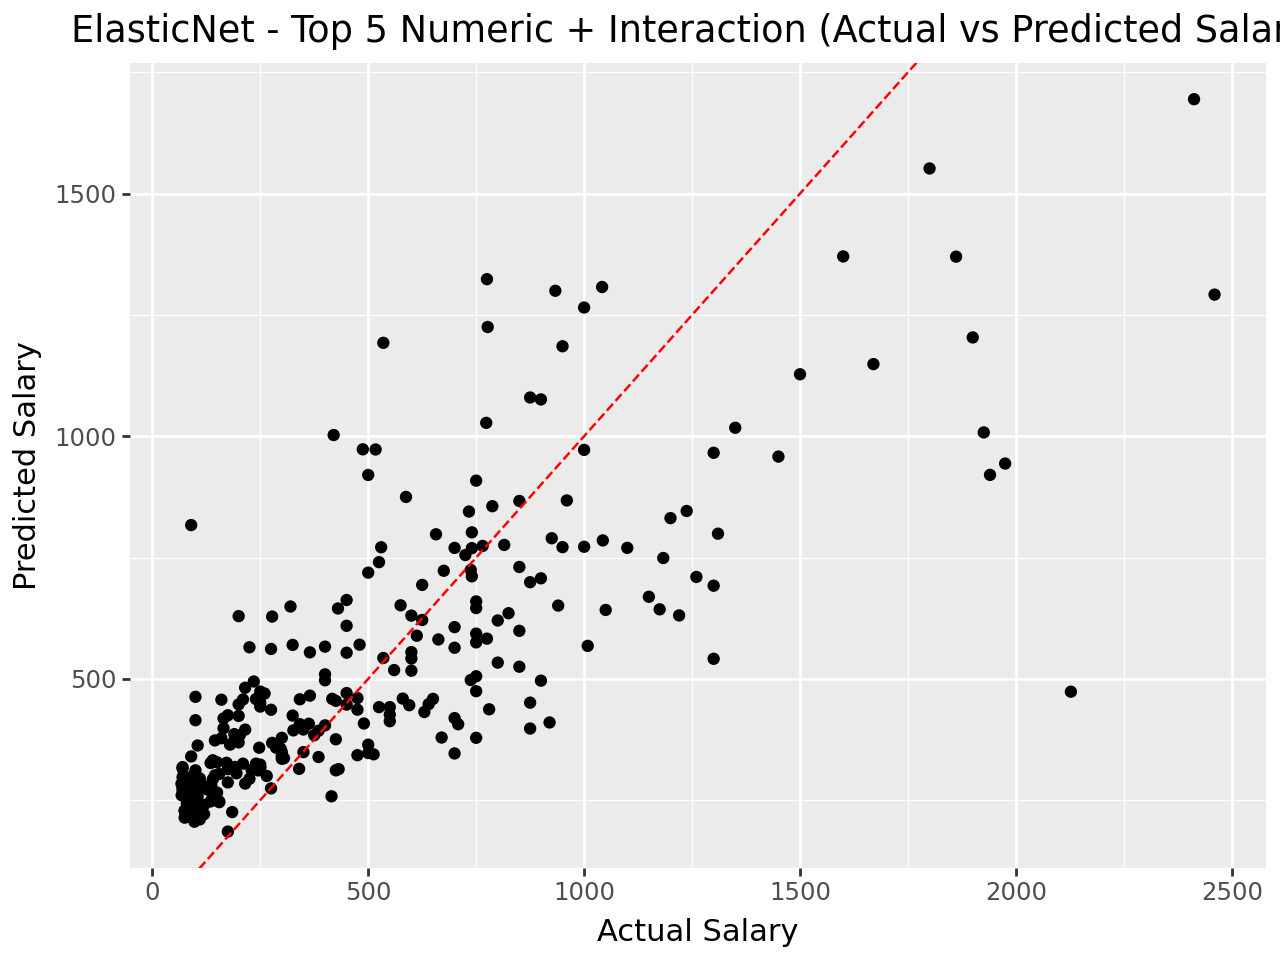

In [ ]:
# Best pipeline is the Elastic Net model with the top 5 numeric variables and interactions

# Define the feature columns (top 5 numeric variables and interactions)
numeric_features = ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits']
categorical_feature = ['Division']

# Create a preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_feature)
    ])


# Create the full pipeline with ElasticNet
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

X_final = df_hitter[[*numeric_features, *categorical_feature]]
y_final = df_hitter['Salary']
pipeline.fit(X, y)

# Get predictions on the full dataset
y_pred = pipeline.predict(X)

# Calculate R-squared and MSE
r2 = r2_score(y, y_pred)
mse = np.mean((y - y_pred)**2)

# Summarize results
print(f"R-squared: {r2:.2f}")
print(f"MSE: {mse:.2f}")


# Create a plot of actual vs predicted values
plot_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
(
    ggplot(plot_df, aes(x='Actual', y='Predicted'))
    + geom_point()
    + geom_abline(intercept=0, slope=1, linetype='dashed', color='red')
    + labs(title='ElasticNet - Top 5 Numeric + Interaction (Actual vs Predicted Salary)', x='Actual Salary', y='Predicted Salary')
)


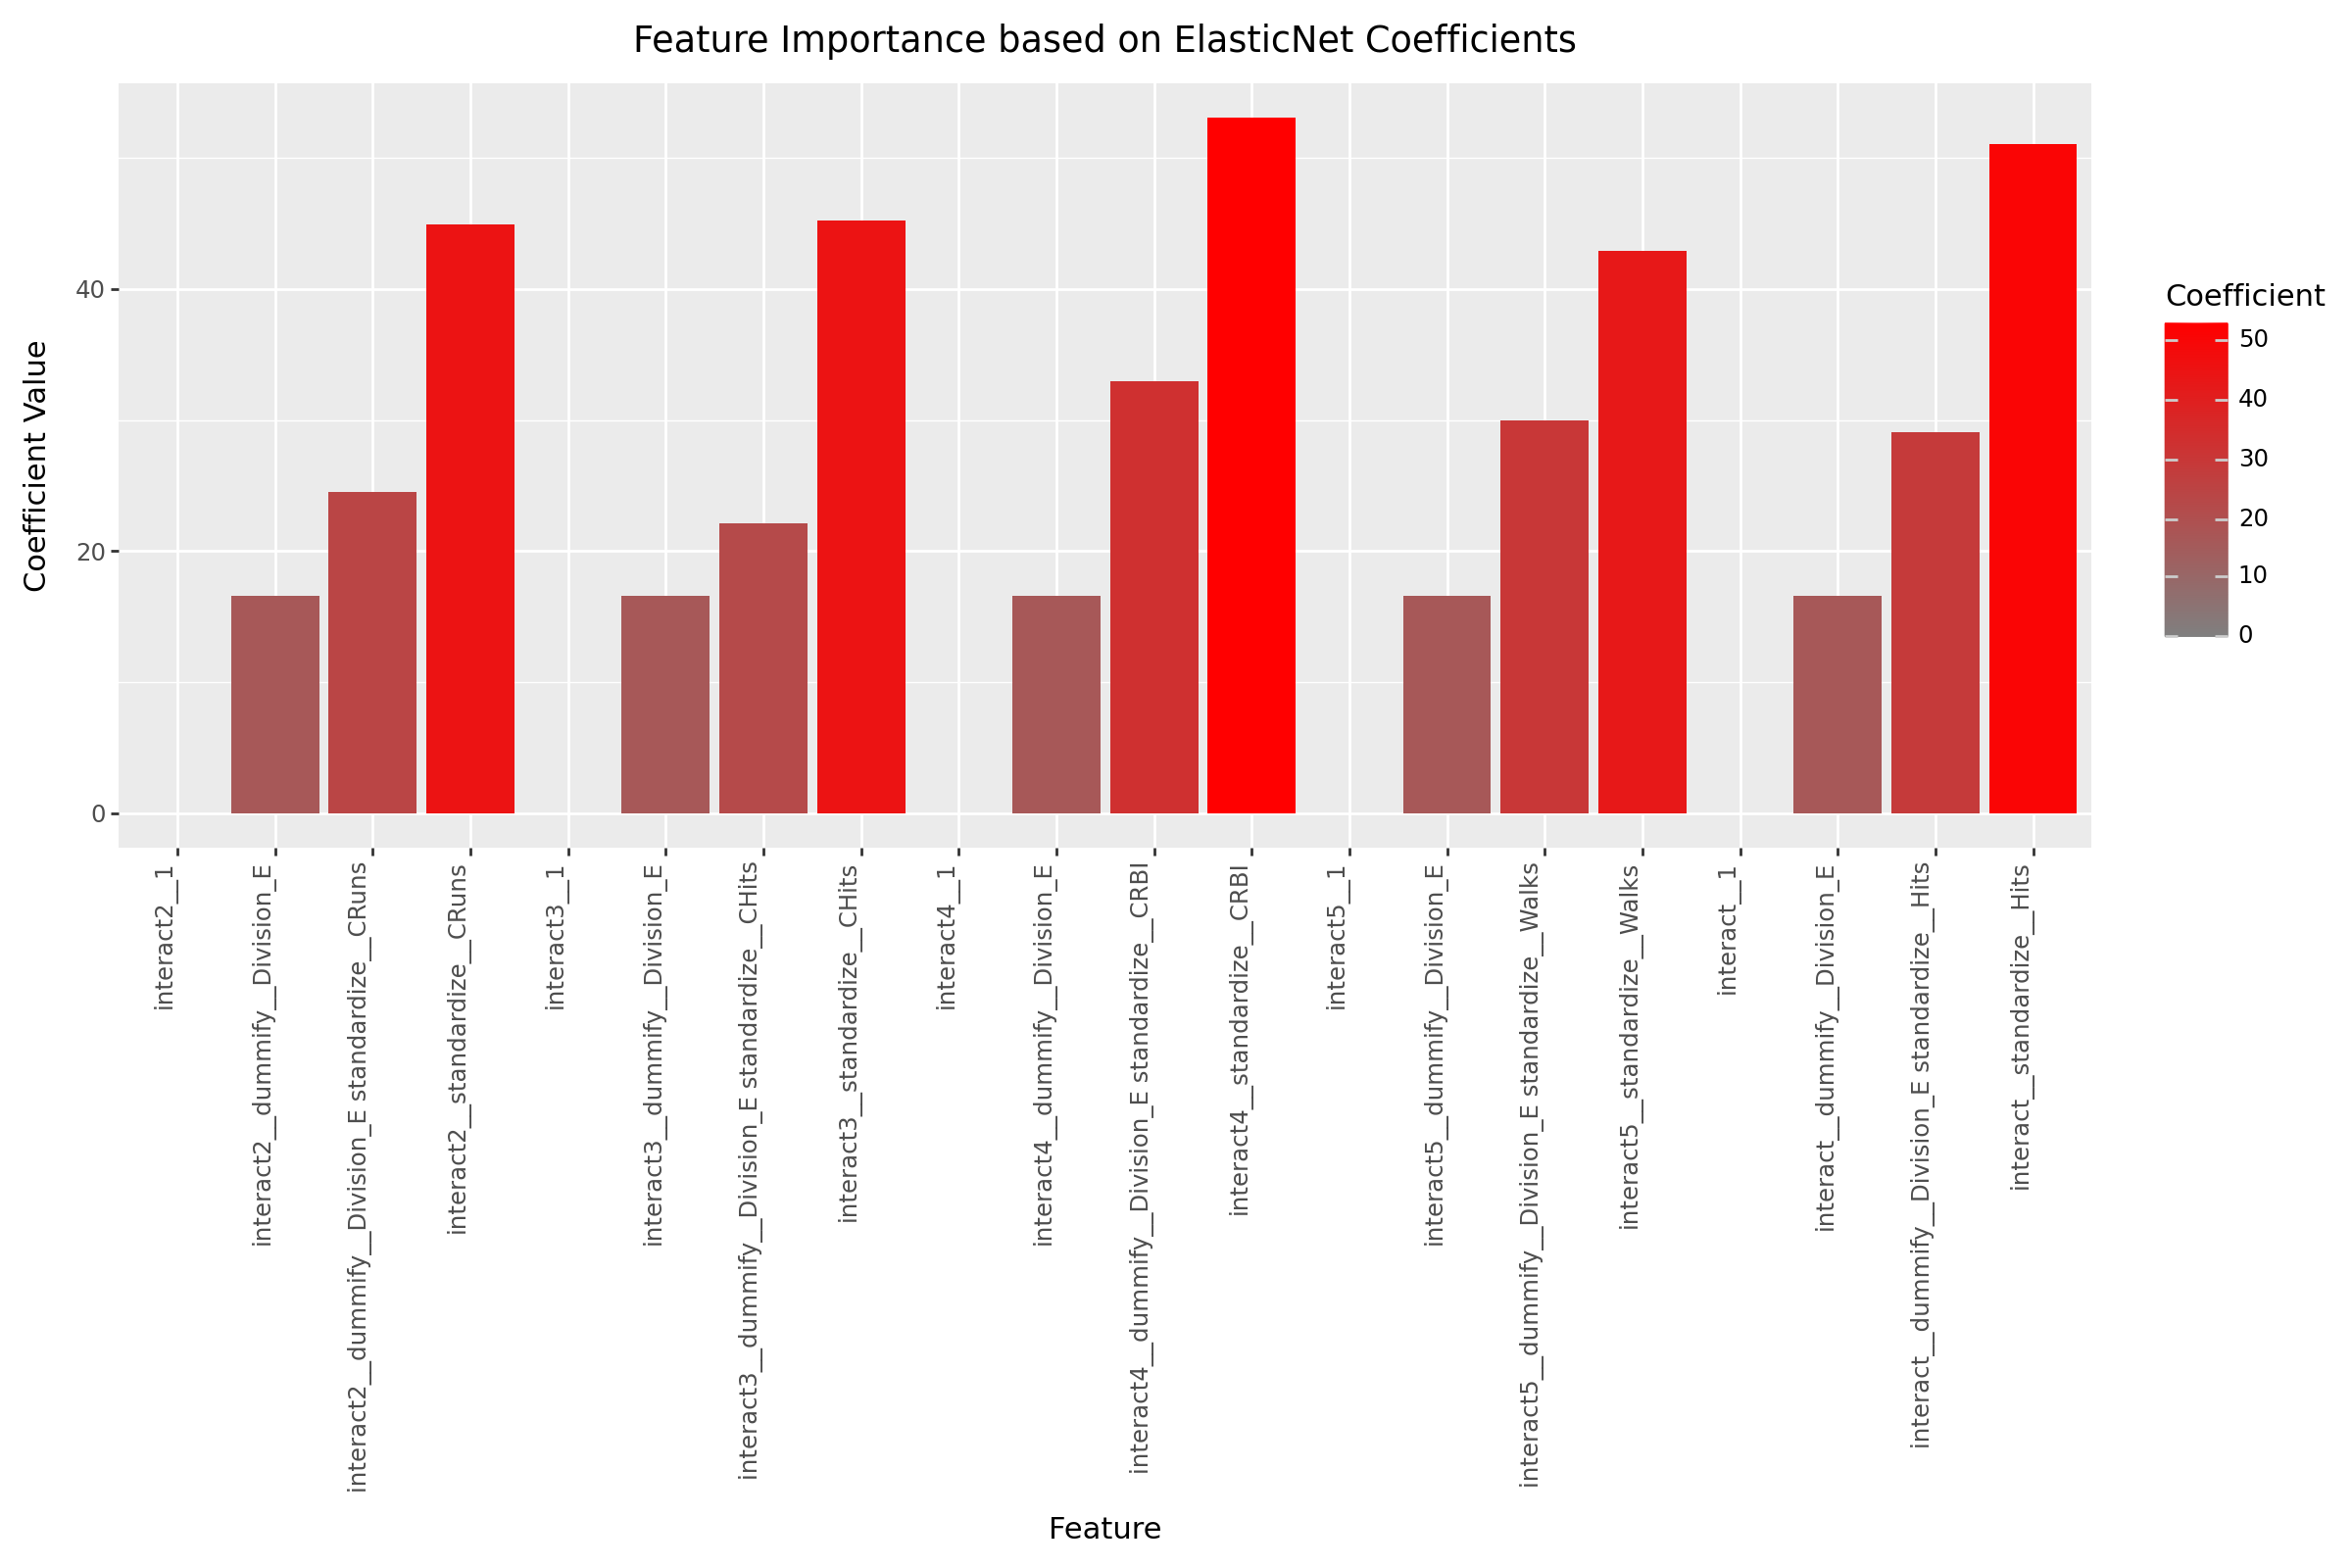

In [ ]:
coefficients = en_df_3['Coefficient']
feature_names = en_df_3['Variable']

plot_data = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

plot_data = plot_data.sort_values('Coefficient', ascending=True)

from plotnine import *

(ggplot(plot_data, aes(x='Feature', y='Coefficient', fill='Coefficient'))
 + geom_bar(stat='identity')
 + scale_fill_gradient2(low="blue", mid="gray", high="red", midpoint=0)
 + labs(title='Feature Importance based on ElasticNet Coefficients',
        x='Feature',
        y='Coefficient Value')
 + theme(axis_text_x=element_text(rotation=90, hjust=1),
         figure_size=(12, 8))
)


For the final model, I fit an Elastic Net regression pipeline on the full dataset, using the top five numeric variables (CRuns, Hits, CRBI, Walks, and CHits) along with their interactions with the categorical variable, Division. This model achieved an R-squared value of 0.58, demonstrating moderate predictive accuracy for the salary variable. The Mean Squared Error (MSE) was 85,801.92, indicating the average squared difference between observed and predicted salary values. In the feature importance plot, key predictors included both main effects and interaction terms, with CRBI, Hits, and their interactions with Division showing substantial coefficients, highlighting their strong influence on the salary predictions. The scatter plot of actual vs. predicted salaries shows a general positive trend, though with some deviation, suggesting room for further optimization.

Overal, The Elastic Net model combines the strengths of both Ridge and Lasso regression, effectively managing multicollinearity while also performing feature selection by shrinking less important coefficients to near-zero. This balance between L1 and L2 regularization allows Elastic Net to handle a high-dimensional dataset like this one, capturing relevant interactions and maintaining robust predictive power. Overall, Elastic Net was the best-performing model due to its ability to retain significant predictors and reduce overfitting, as evidenced by a lower MSE compared to the Ridge and Lasso models individually.








Sources:

[https://stackoverflow.com/questions/57669241/this-is-undefined-outside-from-constructor/57669640#57669640](https://stackoverflow.com/questions/57669241/this-is-undefined-outside-from-constructor/57669640#57669640)

[https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression](https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression)


[https://stackoverflow.com/questions/45313408/keras-custom-layer-attributeerror-tensor-object-has-no-attribute-keras-hi](https://stackoverflow.com/questions/45313408/keras-custom-layer-attributeerror-tensor-object-has-no-attribute-keras-hi)
